In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
import seaborn as sns

In [4]:
X = pd.read_csv('./data/application_train.csv', nrows=None)
X.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocessing
## Solution 3

[Martin Kotek (Competition Host): "Value 365243 denotes infinity in DAYS variables in the datasets, therefore you can consider them NA values. Also XNA/XAP denote NA values."](https://www.kaggle.com/c/home-credit-default-risk/discussion/57247)

In [5]:
X['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [6]:
X.loc[X['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].unique()

array([365243])

In [7]:
sum(X['ORGANIZATION_TYPE'] == 'XNA')

55374

In [8]:
X['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [9]:
X['CODE_GENDER'].replace('XNA',np.nan, inplace=True)
X['CODE_GENDER'].value_counts()

F    202448
M    105059
Name: CODE_GENDER, dtype: int64

# Feature Engineering
## Solution 3
### Hand crafted features

In [10]:
X['annuity_income_percentage'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
X['car_to_birth_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_BIRTH']
X['car_to_employ_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_EMPLOYED']
X['children_ratio'] = X['CNT_CHILDREN'] / X['CNT_FAM_MEMBERS']
X['credit_to_annuity_ratio'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']
X['credit_to_goods_ratio'] = X['AMT_CREDIT'] / X['AMT_GOODS_PRICE']
X['credit_to_income_ratio'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
X['days_employed_percentage'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
X['income_credit_percentage'] = X['AMT_INCOME_TOTAL'] / X['AMT_CREDIT']
X['income_per_child'] = X['AMT_INCOME_TOTAL'] / (1 + X['CNT_CHILDREN'])
X['income_per_person'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']
X['payment_rate'] = X['AMT_ANNUITY'] / X['AMT_CREDIT']
X['phone_to_birth_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_BIRTH']
X['phone_to_employ_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_EMPLOYED']

In [11]:
# External sources
X['external_sources_weighted'] = X.EXT_SOURCE_1 * 2 + X.EXT_SOURCE_2 * 3 + X.EXT_SOURCE_3 * 4
for function_name in ['min', 'max', 'sum', 'mean', 'nanmedian']:
    X['external_sources_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
        X[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

/home/weize/workspace/python/VENV-3.5.2/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [12]:
engineered_numerical_columns = ['annuity_income_percentage',
                                'car_to_birth_ratio',
                                'car_to_employ_ratio',
                                'children_ratio',
                                'credit_to_annuity_ratio',
                                'credit_to_goods_ratio',
                                'credit_to_income_ratio',
                                'days_employed_percentage',
                                'income_credit_percentage',
                                'income_per_child',
                                'income_per_person',
                                'payment_rate',
                                'phone_to_birth_ratio',
                                'phone_to_employ_ratio',
                                'external_sources_weighted',
                                'external_sources_min',
                                'external_sources_max',
                                'external_sources_sum',
                                'external_sources_mean',
                                'external_sources_nanmedian']

In [13]:
X_eng = X[engineered_numerical_columns + ['TARGET']]
X_eng_corr = abs(X_eng.corr())

In [14]:
X_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                        1.000000
external_sources_weighted     0.236289
external_sources_mean         0.222052
external_sources_nanmedian    0.218118
external_sources_max          0.196876
external_sources_min          0.185266
external_sources_sum          0.173322
credit_to_goods_ratio         0.069427
car_to_birth_ratio            0.048824
days_employed_percentage      0.042206
phone_to_birth_ratio          0.033991
credit_to_annuity_ratio       0.032102
car_to_employ_ratio           0.030553
children_ratio                0.021223
annuity_income_percentage     0.014265
payment_rate                  0.012704
income_per_child              0.012529
credit_to_income_ratio        0.007727
income_per_person             0.006571
phone_to_employ_ratio         0.004562
income_credit_percentage      0.001817
Name: TARGET, dtype: float64

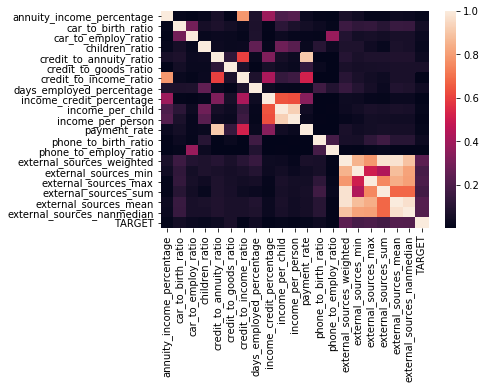

In [15]:
sns.heatmap(X_eng_corr, 
            xticklabels=X_eng_corr.columns,
            yticklabels=X_eng_corr.columns)

### Aggregation features

In [16]:
AGGREGATION_RECIPIES = [
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE'], [('AMT_ANNUITY', 'max'),
                                              ('AMT_CREDIT', 'max'),
                                              ('EXT_SOURCE_1', 'mean'),
                                              ('EXT_SOURCE_2', 'mean'),
                                              ('OWN_CAR_AGE', 'max'),
                                              ('OWN_CAR_AGE', 'sum')]),
    (['CODE_GENDER', 'ORGANIZATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                                            ('AMT_INCOME_TOTAL', 'mean'),
                                            ('DAYS_REGISTRATION', 'mean'),
                                            ('EXT_SOURCE_1', 'mean')]),
    (['CODE_GENDER', 'REG_CITY_NOT_WORK_CITY'], [('AMT_ANNUITY', 'mean'),
                                                 ('CNT_CHILDREN', 'mean'),
                                                 ('DAYS_ID_PUBLISH', 'mean')]),
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('EXT_SOURCE_1', 'mean'),
                                                                                           ('EXT_SOURCE_2', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE'], [('AMT_CREDIT', 'mean'),
                                                  ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                  ('APARTMENTS_AVG', 'mean'),
                                                  ('BASEMENTAREA_AVG', 'mean'),
                                                  ('EXT_SOURCE_1', 'mean'),
                                                  ('EXT_SOURCE_2', 'mean'),
                                                  ('EXT_SOURCE_3', 'mean'),
                                                  ('NONLIVINGAREA_AVG', 'mean'),
                                                  ('OWN_CAR_AGE', 'mean'),
                                                  ('YEARS_BUILD_AVG', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('ELEVATORS_AVG', 'mean'),
                                                                            ('EXT_SOURCE_1', 'mean')]),
    (['OCCUPATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                           ('CNT_CHILDREN', 'mean'),
                           ('CNT_FAM_MEMBERS', 'mean'),
                           ('DAYS_BIRTH', 'mean'),
                           ('DAYS_EMPLOYED', 'mean'),
                           ('DAYS_ID_PUBLISH', 'mean'),
                           ('DAYS_REGISTRATION', 'mean'),
                           ('EXT_SOURCE_1', 'mean'),
                           ('EXT_SOURCE_2', 'mean'),
                           ('EXT_SOURCE_3', 'mean')]),
]

In [17]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    group_object = X.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        X = X.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [19]:
X_agg = X[groupby_aggregate_names + ['TARGET']]
X_agg_corr = abs(X_agg.corr())

In [20]:
X_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                                                                      1.000000
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_1                0.089964
CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_2    0.089231
CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_1    0.086677
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_1                                       0.083520
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_2                                       0.082742
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_ELEVATORS_AVG               0.078057
OCCUPATION_TYPE_mean_EXT_SOURCE_1                                                           0.076587
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_AMT_REQ_CREDIT_BUREAU_YEAR                         0.074528
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_YEARS_BUILD_AVG                                   

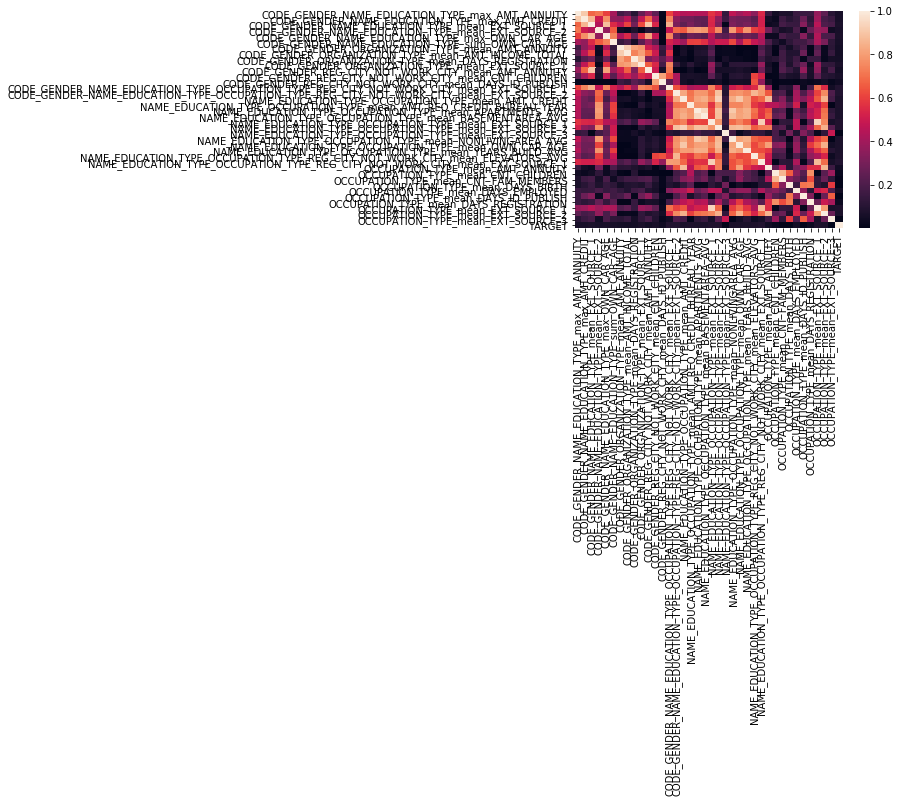

In [22]:
sns.heatmap(X_agg_corr, 
            xticklabels=X_agg_corr.columns,
            yticklabels=X_agg_corr.columns)

In [28]:
X_final = X_eng
X_final = X_final.replace(-np.inf, np.nan)
X_final = X_final.fillna(X_final.median())
# X_final.head()
# np.where(X_final.values >= np.finfo(np.float64).max)
from sklearn import svm
from sklearn.model_selection import train_test_split
arr = X_final.as_matrix()
Y_ = arr[:,-1:]
X_ = arr[:,:-1]

for random_state in range(1):
    X_train, X_val, y_train, y_val = train_test_split(X_, Y_, test_size=0.3, random_state=random_state)
    clf = svm.SVC(kernel='rbf', C=1, class_weight="balanced").fit(X_train, y_train)
    print(clf.score(X_val, y_val))

/home/weize/workspace/python/VENV-3.5.2/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.692143430095172


In [20]:
X_test = pd.read_csv('./data/application_test.csv', nrows=None)

In [29]:
X_test['CODE_GENDER'].replace('XNA', np.nan, inplace = True)
X_test['annuity_income_percentage'] = X_test['AMT_ANNUITY'] / X_test['AMT_INCOME_TOTAL']
X_test['car_to_birth_ratio'] = X_test['OWN_CAR_AGE'] / X_test['DAYS_BIRTH']
X_test['car_to_employ_ratio'] = X_test['OWN_CAR_AGE'] / X_test['DAYS_EMPLOYED']
X_test['children_ratio'] = X_test['CNT_CHILDREN'] / X_test['CNT_FAM_MEMBERS']
X_test['credit_to_annuity_ratio'] = X_test['AMT_CREDIT'] / X_test['AMT_ANNUITY']
X_test['credit_to_goods_ratio'] = X_test['AMT_CREDIT'] / X_test['AMT_GOODS_PRICE']
X_test['credit_to_income_ratio'] = X_test['AMT_CREDIT'] / X_test['AMT_INCOME_TOTAL']
X_test['days_employed_percentage'] = X_test['DAYS_EMPLOYED'] / X_test['DAYS_BIRTH']
X_test['income_credit_percentage'] = X_test['AMT_INCOME_TOTAL'] / X_test['AMT_CREDIT']
X_test['income_per_child'] = X_test['AMT_INCOME_TOTAL'] / (1 + X_test['CNT_CHILDREN'])
X_test['income_per_person'] = X_test['AMT_INCOME_TOTAL'] / X_test['CNT_FAM_MEMBERS']
X_test['payment_rate'] = X_test['AMT_ANNUITY'] / X_test['AMT_CREDIT']
X_test['phone_to_birth_ratio'] = X_test['DAYS_LAST_PHONE_CHANGE'] / X_test['DAYS_BIRTH']
X_test['phone_to_employ_ratio'] = X_test['DAYS_LAST_PHONE_CHANGE'] / X_test['DAYS_EMPLOYED']
# External sources
X_test['external_sources_weighted'] = X_test.EXT_SOURCE_1 * 2 + X_test.EXT_SOURCE_2 * 3 + X_test.EXT_SOURCE_3 * 4
for function_name in ['min', 'max', 'sum', 'mean', 'nanmedian']:
    X_test['external_sources_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
        X_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)
engineered_numerical_columns = ['annuity_income_percentage',
                                'car_to_birth_ratio',
                                'car_to_employ_ratio',
                                'children_ratio',
                                'credit_to_annuity_ratio',
                                'credit_to_goods_ratio',
                                'credit_to_income_ratio',
                                'days_employed_percentage',
                                'income_credit_percentage',
                                'income_per_child',
                                'income_per_person',
                                'payment_rate',
                                'phone_to_birth_ratio',
                                'phone_to_employ_ratio',
                                'external_sources_weighted',
                                'external_sources_min',
                                'external_sources_max',
                                'external_sources_sum',
                                'external_sources_mean',
                                'external_sources_nanmedian']
X_eng_test = X_test[engineered_numerical_columns]
X_test_final = X_eng_test
X_test_final = X_test_final.replace(-np.inf, np.nan)
X_test_final = X_test_final.fillna(X_test_final.median())
y_test = clf.predict(X_test_final.values)
for i in range(len(y_test)):
    print(X_test.values[i][0], y_test[i])

/home/weize/workspace/python/VENV-3.5.2/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


100001 0.0
100005 1.0
100013 0.0
100028 0.0
100038 1.0
100042 0.0
100057 0.0
100065 1.0
100066 0.0
100067 0.0
100074 0.0
100090 1.0
100091 1.0
100092 1.0
100106 0.0
100107 1.0
100109 1.0
100117 0.0
100128 1.0
100141 0.0
100150 0.0
100168 0.0
100169 0.0
100170 0.0
100171 0.0
100172 0.0
100184 1.0
100187 1.0
100212 1.0
100222 1.0
100223 0.0
100232 0.0
100241 1.0
100245 0.0
100253 0.0
100256 1.0
100271 0.0
100278 1.0
100280 0.0
100306 1.0
100311 0.0
100312 0.0
100330 1.0
100331 0.0
100352 1.0
100358 1.0
100367 0.0
100382 1.0
100384 1.0
100385 0.0
100386 1.0
100399 0.0
100404 0.0
100416 0.0
100422 1.0
100426 0.0
100438 1.0
100444 0.0
100445 0.0
100446 1.0
100447 0.0
100450 0.0
100466 1.0
100483 0.0
100484 0.0
100494 0.0
100510 0.0
100512 0.0
100517 1.0
100548 0.0
100551 0.0
100552 0.0
100553 0.0
100561 1.0
100568 1.0
100569 0.0
100591 1.0
100592 0.0
100602 1.0
100607 0.0
100613 1.0
100617 1.0
100618 0.0
100622 0.0
100625 1.0
100677 0.0
100699 1.0
100702 1.0
100711 0.0
100729 1.0
100740 1.0

105172 0.0
105176 1.0
105195 1.0
105196 1.0
105197 0.0
105203 0.0
105223 0.0
105227 0.0
105228 0.0
105230 0.0
105231 1.0
105239 0.0
105242 0.0
105244 0.0
105245 0.0
105248 1.0
105249 0.0
105266 1.0
105271 1.0
105276 0.0
105282 0.0
105292 0.0
105297 0.0
105332 0.0
105333 0.0
105343 0.0
105344 0.0
105345 1.0
105357 0.0
105359 0.0
105366 0.0
105367 0.0
105370 0.0
105377 0.0
105390 0.0
105399 0.0
105403 0.0
105404 0.0
105414 1.0
105417 1.0
105425 1.0
105452 1.0
105454 0.0
105456 1.0
105470 0.0
105471 0.0
105483 1.0
105493 0.0
105508 1.0
105514 0.0
105515 0.0
105528 1.0
105529 0.0
105531 0.0
105532 0.0
105558 0.0
105574 0.0
105578 0.0
105584 1.0
105595 0.0
105617 0.0
105618 0.0
105621 0.0
105625 1.0
105629 0.0
105630 0.0
105634 0.0
105635 0.0
105641 1.0
105647 1.0
105648 1.0
105655 0.0
105657 0.0
105672 1.0
105678 1.0
105682 1.0
105691 1.0
105692 0.0
105706 0.0
105712 0.0
105720 0.0
105734 0.0
105735 0.0
105736 1.0
105737 0.0
105738 1.0
105740 1.0
105744 1.0
105747 0.0
105749 0.0
105754 0.0

110681 0.0
110682 0.0
110687 1.0
110691 0.0
110694 1.0
110695 0.0
110696 0.0
110708 0.0
110710 0.0
110717 0.0
110730 0.0
110740 0.0
110742 0.0
110747 0.0
110761 0.0
110766 0.0
110769 0.0
110774 0.0
110803 0.0
110805 1.0
110809 1.0
110827 0.0
110832 0.0
110839 1.0
110859 0.0
110861 0.0
110863 0.0
110865 0.0
110881 1.0
110889 0.0
110891 0.0
110894 1.0
110895 1.0
110907 1.0
110914 1.0
110933 0.0
110934 0.0
110937 0.0
110953 0.0
110954 1.0
110958 1.0
110970 0.0
110974 1.0
110977 1.0
110989 0.0
110993 1.0
110994 0.0
111018 0.0
111019 0.0
111030 1.0
111032 1.0
111041 0.0
111045 0.0
111048 0.0
111052 0.0
111070 1.0
111084 0.0
111091 1.0
111104 0.0
111108 0.0
111112 0.0
111127 0.0
111142 0.0
111146 0.0
111165 0.0
111168 0.0
111169 1.0
111172 0.0
111173 0.0
111174 0.0
111175 0.0
111176 0.0
111177 0.0
111180 0.0
111182 0.0
111192 0.0
111194 1.0
111196 1.0
111197 1.0
111198 0.0
111205 0.0
111207 1.0
111222 0.0
111228 0.0
111233 0.0
111256 0.0
111258 0.0
111262 1.0
111263 1.0
111267 0.0
111269 0.0

115781 1.0
115801 1.0
115804 1.0
115810 1.0
115812 1.0
115820 1.0
115827 0.0
115831 1.0
115841 1.0
115846 1.0
115852 0.0
115857 0.0
115858 1.0
115860 0.0
115865 0.0
115867 1.0
115869 1.0
115877 0.0
115904 0.0
115913 0.0
115916 0.0
115928 1.0
115932 1.0
115933 0.0
115937 1.0
115938 0.0
115957 0.0
115958 0.0
115969 0.0
115980 0.0
115984 0.0
116006 1.0
116007 0.0
116008 0.0
116009 0.0
116011 0.0
116012 0.0
116015 1.0
116025 0.0
116047 0.0
116052 1.0
116068 0.0
116077 0.0
116084 0.0
116089 0.0
116093 0.0
116097 1.0
116102 0.0
116118 0.0
116119 0.0
116125 0.0
116128 1.0
116135 0.0
116140 1.0
116141 0.0
116142 0.0
116153 0.0
116156 1.0
116157 0.0
116167 0.0
116168 0.0
116175 0.0
116187 0.0
116189 0.0
116191 0.0
116201 0.0
116210 0.0
116213 0.0
116215 1.0
116223 0.0
116226 0.0
116228 0.0
116241 0.0
116247 0.0
116266 0.0
116276 1.0
116287 0.0
116289 0.0
116292 0.0
116306 0.0
116309 0.0
116312 0.0
116313 1.0
116335 0.0
116342 0.0
116348 0.0
116367 0.0
116380 0.0
116383 1.0
116389 0.0
116395 0.0

120953 0.0
120955 0.0
120956 1.0
120977 0.0
120980 1.0
120981 0.0
120982 0.0
120991 1.0
121011 0.0
121013 0.0
121018 0.0
121020 0.0
121037 0.0
121038 0.0
121039 0.0
121045 1.0
121046 0.0
121059 0.0
121066 1.0
121078 0.0
121080 1.0
121081 0.0
121086 1.0
121099 1.0
121100 0.0
121107 1.0
121108 1.0
121111 0.0
121130 0.0
121131 1.0
121135 0.0
121152 0.0
121156 0.0
121160 1.0
121162 1.0
121175 1.0
121181 0.0
121186 0.0
121197 0.0
121201 1.0
121208 0.0
121215 1.0
121220 1.0
121225 0.0
121227 0.0
121228 0.0
121243 0.0
121258 1.0
121259 0.0
121265 0.0
121279 0.0
121280 1.0
121281 0.0
121283 0.0
121288 0.0
121296 0.0
121300 1.0
121308 1.0
121321 1.0
121323 0.0
121332 0.0
121334 0.0
121348 0.0
121350 0.0
121351 0.0
121363 0.0
121379 1.0
121380 0.0
121383 1.0
121387 1.0
121414 0.0
121416 0.0
121422 1.0
121423 0.0
121427 1.0
121431 0.0
121438 1.0
121460 1.0
121479 0.0
121482 0.0
121483 1.0
121488 0.0
121489 1.0
121492 0.0
121502 0.0
121503 0.0
121513 0.0
121544 0.0
121545 0.0
121546 0.0
121552 1.0

126533 1.0
126538 0.0
126549 1.0
126553 0.0
126554 0.0
126555 0.0
126579 1.0
126584 1.0
126594 0.0
126595 0.0
126596 1.0
126602 0.0
126611 0.0
126614 0.0
126636 0.0
126638 1.0
126651 1.0
126658 1.0
126674 0.0
126685 0.0
126688 1.0
126689 0.0
126707 1.0
126715 0.0
126716 0.0
126721 0.0
126722 0.0
126732 1.0
126738 0.0
126743 0.0
126744 0.0
126752 0.0
126759 1.0
126763 1.0
126775 1.0
126778 1.0
126784 0.0
126791 1.0
126792 0.0
126804 1.0
126816 1.0
126817 0.0
126822 0.0
126832 1.0
126842 0.0
126849 0.0
126850 1.0
126861 0.0
126871 0.0
126872 1.0
126880 1.0
126888 0.0
126896 0.0
126913 1.0
126918 0.0
126954 0.0
126961 0.0
126963 0.0
126965 1.0
126968 0.0
126971 0.0
126981 0.0
126984 0.0
126985 1.0
126995 0.0
126999 0.0
127007 0.0
127015 0.0
127038 1.0
127054 0.0
127057 0.0
127062 1.0
127083 0.0
127098 0.0
127102 0.0
127110 0.0
127111 0.0
127116 0.0
127126 0.0
127135 0.0
127137 1.0
127142 1.0
127151 0.0
127155 0.0
127156 0.0
127160 0.0
127169 0.0
127174 0.0
127175 0.0
127177 0.0
127192 0.0

132061 0.0
132062 1.0
132078 1.0
132082 0.0
132086 0.0
132089 0.0
132095 0.0
132109 0.0
132110 0.0
132121 0.0
132125 0.0
132127 1.0
132128 0.0
132134 0.0
132139 0.0
132141 0.0
132149 1.0
132150 0.0
132152 0.0
132153 0.0
132164 0.0
132179 1.0
132182 0.0
132189 0.0
132193 1.0
132194 0.0
132195 0.0
132208 1.0
132211 0.0
132212 1.0
132216 0.0
132219 0.0
132223 0.0
132238 1.0
132242 0.0
132268 0.0
132275 0.0
132276 0.0
132279 0.0
132289 1.0
132290 0.0
132300 0.0
132319 0.0
132340 0.0
132344 1.0
132345 0.0
132346 1.0
132352 0.0
132353 0.0
132358 1.0
132381 0.0
132382 0.0
132383 1.0
132410 0.0
132419 0.0
132423 1.0
132432 0.0
132434 0.0
132440 0.0
132441 1.0
132452 0.0
132453 0.0
132456 1.0
132459 0.0
132462 0.0
132463 1.0
132468 1.0
132485 1.0
132490 0.0
132500 0.0
132521 1.0
132555 1.0
132560 0.0
132562 0.0
132575 1.0
132587 0.0
132591 1.0
132611 0.0
132615 0.0
132617 0.0
132622 1.0
132629 0.0
132638 0.0
132642 0.0
132658 0.0
132664 0.0
132668 0.0
132676 0.0
132704 1.0
132707 1.0
132719 0.0

138087 0.0
138089 0.0
138100 0.0
138105 0.0
138107 0.0
138127 0.0
138128 1.0
138129 1.0
138131 0.0
138132 0.0
138150 0.0
138156 0.0
138169 1.0
138174 0.0
138177 0.0
138187 1.0
138189 0.0
138193 0.0
138203 0.0
138209 0.0
138237 0.0
138243 0.0
138273 0.0
138274 0.0
138275 0.0
138277 0.0
138285 0.0
138289 0.0
138308 0.0
138313 0.0
138317 0.0
138326 1.0
138327 1.0
138338 0.0
138367 1.0
138377 1.0
138416 1.0
138417 0.0
138419 0.0
138425 0.0
138430 0.0
138454 0.0
138465 0.0
138470 0.0
138480 0.0
138481 1.0
138486 0.0
138492 0.0
138496 0.0
138519 1.0
138520 0.0
138522 1.0
138545 0.0
138556 1.0
138560 0.0
138564 0.0
138573 1.0
138581 0.0
138585 0.0
138591 0.0
138598 0.0
138600 1.0
138602 0.0
138613 1.0
138639 1.0
138651 0.0
138652 1.0
138661 1.0
138674 0.0
138678 1.0
138679 0.0
138686 0.0
138695 0.0
138711 0.0
138728 1.0
138731 0.0
138744 0.0
138752 1.0
138754 1.0
138756 1.0
138770 0.0
138771 1.0
138807 0.0
138818 0.0
138819 1.0
138820 0.0
138831 0.0
138843 0.0
138871 0.0
138873 1.0
138876 0.0

143679 0.0
143680 0.0
143692 0.0
143703 0.0
143712 1.0
143714 1.0
143715 0.0
143729 1.0
143732 1.0
143738 0.0
143740 0.0
143743 1.0
143772 0.0
143773 0.0
143792 0.0
143802 0.0
143808 0.0
143819 0.0
143820 1.0
143825 0.0
143828 0.0
143831 0.0
143834 0.0
143835 0.0
143843 0.0
143860 0.0
143874 0.0
143889 1.0
143903 0.0
143921 1.0
143936 1.0
143944 0.0
143947 1.0
143948 0.0
143957 0.0
143964 1.0
143965 0.0
143971 0.0
143976 1.0
143977 1.0
143983 1.0
143991 0.0
144015 0.0
144032 0.0
144057 0.0
144065 0.0
144087 0.0
144090 0.0
144091 0.0
144092 1.0
144139 0.0
144150 0.0
144151 0.0
144153 1.0
144154 1.0
144159 1.0
144168 0.0
144169 1.0
144178 1.0
144179 0.0
144183 0.0
144186 1.0
144190 0.0
144191 0.0
144199 1.0
144226 1.0
144227 0.0
144229 0.0
144237 0.0
144247 0.0
144249 1.0
144259 1.0
144260 0.0
144282 0.0
144295 0.0
144304 0.0
144314 0.0
144318 1.0
144324 0.0
144325 0.0
144333 0.0
144334 0.0
144336 0.0
144350 1.0
144354 1.0
144357 0.0
144359 0.0
144365 1.0
144385 0.0
144386 0.0
144387 0.0

149341 1.0
149342 0.0
149349 0.0
149351 0.0
149354 0.0
149360 0.0
149362 0.0
149366 0.0
149372 1.0
149376 0.0
149388 0.0
149393 0.0
149401 0.0
149405 0.0
149412 1.0
149415 0.0
149416 0.0
149430 0.0
149435 0.0
149436 0.0
149444 0.0
149456 0.0
149471 0.0
149480 0.0
149481 0.0
149490 1.0
149491 1.0
149503 0.0
149512 0.0
149524 0.0
149525 0.0
149532 0.0
149533 1.0
149536 0.0
149540 0.0
149548 0.0
149563 0.0
149568 1.0
149569 1.0
149570 1.0
149582 0.0
149584 1.0
149587 1.0
149592 1.0
149596 0.0
149599 0.0
149612 0.0
149643 0.0
149648 1.0
149665 0.0
149666 1.0
149671 0.0
149675 0.0
149676 1.0
149677 0.0
149680 1.0
149711 0.0
149723 0.0
149726 0.0
149727 0.0
149730 0.0
149733 0.0
149734 1.0
149736 1.0
149750 0.0
149752 0.0
149767 0.0
149791 1.0
149793 0.0
149810 0.0
149850 0.0
149857 0.0
149858 0.0
149860 1.0
149882 0.0
149889 0.0
149890 1.0
149918 0.0
149919 1.0
149927 0.0
149928 0.0
149940 0.0
149944 0.0
149947 1.0
149951 1.0
149956 1.0
149958 0.0
149969 0.0
149988 0.0
149996 0.0
150007 0.0

154681 0.0
154690 0.0
154711 0.0
154712 0.0
154722 0.0
154731 0.0
154747 1.0
154749 1.0
154750 0.0
154760 1.0
154763 0.0
154786 1.0
154788 0.0
154792 1.0
154807 1.0
154812 0.0
154818 0.0
154819 1.0
154824 1.0
154839 0.0
154840 0.0
154843 0.0
154847 1.0
154849 0.0
154850 0.0
154851 0.0
154853 1.0
154858 0.0
154868 1.0
154871 0.0
154877 0.0
154916 0.0
154920 0.0
154922 0.0
154924 0.0
154933 1.0
154942 0.0
154955 0.0
154957 1.0
154966 0.0
154971 0.0
154972 1.0
154973 0.0
154974 0.0
154979 1.0
154982 1.0
154990 1.0
154991 0.0
154994 0.0
154995 1.0
155009 0.0
155014 0.0
155017 0.0
155018 0.0
155019 0.0
155020 0.0
155027 0.0
155034 1.0
155047 0.0
155049 1.0
155052 1.0
155053 0.0
155059 1.0
155060 1.0
155069 0.0
155077 1.0
155078 0.0
155086 0.0
155088 1.0
155094 0.0
155099 0.0
155100 0.0
155116 1.0
155117 0.0
155119 0.0
155120 0.0
155133 0.0
155135 1.0
155141 1.0
155144 0.0
155145 0.0
155174 1.0
155194 0.0
155196 0.0
155204 0.0
155232 1.0
155240 0.0
155246 0.0
155254 0.0
155267 0.0
155273 1.0

160116 0.0
160119 0.0
160123 0.0
160141 0.0
160147 0.0
160151 0.0
160172 1.0
160173 0.0
160177 1.0
160178 0.0
160180 0.0
160181 1.0
160188 0.0
160189 0.0
160193 0.0
160205 0.0
160214 0.0
160215 1.0
160217 0.0
160262 0.0
160263 0.0
160273 0.0
160282 1.0
160295 1.0
160297 0.0
160303 0.0
160305 0.0
160309 0.0
160324 0.0
160338 1.0
160366 1.0
160375 0.0
160381 0.0
160398 0.0
160400 0.0
160406 0.0
160410 0.0
160411 0.0
160418 0.0
160440 0.0
160441 1.0
160450 1.0
160465 0.0
160470 1.0
160471 0.0
160472 0.0
160479 1.0
160490 1.0
160500 1.0
160503 0.0
160504 1.0
160515 0.0
160541 1.0
160545 1.0
160562 1.0
160589 0.0
160594 0.0
160595 0.0
160598 0.0
160601 0.0
160605 0.0
160606 0.0
160607 0.0
160608 1.0
160610 1.0
160614 1.0
160615 1.0
160626 0.0
160634 0.0
160656 1.0
160660 0.0
160666 0.0
160672 0.0
160673 0.0
160674 0.0
160681 0.0
160683 0.0
160694 0.0
160710 1.0
160715 1.0
160719 0.0
160732 1.0
160734 0.0
160737 1.0
160742 0.0
160747 0.0
160749 0.0
160753 1.0
160756 0.0
160757 1.0
160763 0.0

165386 0.0
165410 0.0
165422 0.0
165426 1.0
165428 0.0
165445 0.0
165452 0.0
165454 0.0
165455 0.0
165462 0.0
165465 0.0
165466 1.0
165467 1.0
165476 0.0
165477 0.0
165478 1.0
165497 0.0
165500 0.0
165511 1.0
165513 1.0
165515 0.0
165521 0.0
165522 0.0
165523 0.0
165530 0.0
165537 0.0
165538 0.0
165539 0.0
165545 0.0
165550 0.0
165551 0.0
165552 1.0
165557 0.0
165558 1.0
165560 0.0
165574 1.0
165576 1.0
165587 0.0
165601 0.0
165605 0.0
165606 0.0
165607 0.0
165624 1.0
165632 0.0
165633 1.0
165634 1.0
165646 0.0
165649 0.0
165651 1.0
165661 0.0
165666 0.0
165669 1.0
165674 0.0
165685 1.0
165687 0.0
165692 0.0
165721 0.0
165726 1.0
165748 0.0
165749 1.0
165752 0.0
165755 1.0
165758 0.0
165761 1.0
165762 0.0
165780 0.0
165781 0.0
165789 1.0
165802 0.0
165806 0.0
165817 1.0
165822 1.0
165837 0.0
165840 1.0
165846 0.0
165853 0.0
165864 0.0
165865 1.0
165868 0.0
165869 1.0
165871 0.0
165880 1.0
165887 0.0
165904 0.0
165907 0.0
165910 1.0
165915 1.0
165917 0.0
165918 1.0
165919 0.0
165923 0.0

170435 0.0
170438 0.0
170442 1.0
170446 1.0
170461 0.0
170473 1.0
170477 0.0
170516 0.0
170517 0.0
170522 1.0
170523 0.0
170534 1.0
170535 0.0
170538 0.0
170549 0.0
170556 0.0
170563 0.0
170570 0.0
170580 0.0
170582 0.0
170584 1.0
170585 0.0
170587 0.0
170590 1.0
170598 0.0
170599 0.0
170601 0.0
170612 1.0
170617 1.0
170620 1.0
170629 0.0
170647 1.0
170651 0.0
170654 0.0
170657 1.0
170662 0.0
170707 1.0
170719 1.0
170722 0.0
170723 0.0
170731 1.0
170735 0.0
170750 0.0
170769 0.0
170770 0.0
170776 0.0
170783 0.0
170789 1.0
170800 1.0
170809 1.0
170810 0.0
170811 0.0
170827 0.0
170842 0.0
170854 1.0
170857 0.0
170865 1.0
170867 0.0
170869 0.0
170870 1.0
170878 0.0
170881 1.0
170910 1.0
170913 1.0
170919 1.0
170932 1.0
170939 1.0
170947 0.0
170950 1.0
170953 1.0
170954 0.0
170970 1.0
170972 0.0
170973 0.0
170980 0.0
170981 1.0
170983 1.0
170998 1.0
171001 0.0
171004 0.0
171020 1.0
171023 1.0
171026 0.0
171060 1.0
171061 0.0
171065 1.0
171077 1.0
171081 0.0
171103 1.0
171110 1.0
171114 0.0

175798 1.0
175809 1.0
175818 0.0
175830 0.0
175835 0.0
175840 1.0
175864 0.0
175875 0.0
175890 0.0
175892 0.0
175914 0.0
175930 1.0
175935 1.0
175955 0.0
175958 1.0
175959 0.0
175960 0.0
175964 0.0
175968 0.0
175986 1.0
175987 1.0
175997 1.0
175998 1.0
176003 0.0
176004 1.0
176021 0.0
176034 0.0
176035 0.0
176043 1.0
176045 0.0
176051 1.0
176052 0.0
176059 0.0
176067 1.0
176073 0.0
176076 1.0
176077 0.0
176085 0.0
176088 1.0
176095 0.0
176118 1.0
176129 1.0
176177 0.0
176183 0.0
176206 1.0
176218 0.0
176240 0.0
176253 0.0
176260 1.0
176275 1.0
176285 0.0
176288 1.0
176289 1.0
176290 1.0
176297 1.0
176300 1.0
176301 0.0
176319 1.0
176322 0.0
176337 0.0
176346 1.0
176347 1.0
176352 1.0
176358 0.0
176359 0.0
176365 1.0
176371 0.0
176403 0.0
176419 0.0
176428 0.0
176429 1.0
176430 1.0
176432 0.0
176437 1.0
176440 0.0
176441 1.0
176450 0.0
176454 0.0
176459 0.0
176460 1.0
176467 0.0
176472 1.0
176482 0.0
176483 1.0
176486 1.0
176487 0.0
176494 0.0
176497 0.0
176500 1.0
176509 1.0
176511 0.0

181117 1.0
181157 0.0
181160 0.0
181161 0.0
181165 1.0
181179 1.0
181186 0.0
181196 1.0
181197 1.0
181204 1.0
181213 0.0
181214 1.0
181221 0.0
181224 1.0
181226 0.0
181236 1.0
181256 1.0
181257 0.0
181279 0.0
181282 0.0
181285 1.0
181288 0.0
181289 1.0
181290 0.0
181298 0.0
181299 0.0
181307 0.0
181312 1.0
181318 0.0
181322 1.0
181338 0.0
181340 0.0
181342 0.0
181344 0.0
181350 0.0
181373 0.0
181374 0.0
181375 0.0
181379 1.0
181381 0.0
181385 1.0
181388 0.0
181392 1.0
181393 0.0
181425 0.0
181465 0.0
181481 1.0
181484 0.0
181494 0.0
181501 1.0
181507 0.0
181521 0.0
181524 0.0
181538 1.0
181540 0.0
181547 1.0
181551 0.0
181555 0.0
181561 0.0
181564 0.0
181567 1.0
181599 0.0
181602 0.0
181612 0.0
181613 0.0
181615 0.0
181621 0.0
181622 0.0
181629 0.0
181630 0.0
181633 1.0
181635 0.0
181641 0.0
181643 1.0
181644 1.0
181649 0.0
181659 0.0
181660 0.0
181665 0.0
181666 0.0
181672 0.0
181682 1.0
181693 1.0
181697 0.0
181703 0.0
181704 1.0
181720 0.0
181722 0.0
181732 1.0
181733 0.0
181736 0.0

186695 1.0
186696 0.0
186704 0.0
186709 1.0
186714 0.0
186723 0.0
186726 1.0
186728 0.0
186729 0.0
186731 1.0
186737 0.0
186742 0.0
186743 0.0
186745 1.0
186747 0.0
186750 1.0
186769 0.0
186771 0.0
186787 0.0
186796 0.0
186802 0.0
186811 0.0
186812 1.0
186815 0.0
186840 0.0
186842 1.0
186853 1.0
186859 0.0
186878 1.0
186885 0.0
186890 0.0
186906 1.0
186916 0.0
186927 0.0
186928 0.0
186931 1.0
186934 0.0
186938 1.0
186943 1.0
186944 0.0
186945 0.0
186947 0.0
186952 1.0
186953 0.0
186960 1.0
186962 1.0
186991 0.0
187001 1.0
187017 0.0
187019 1.0
187024 0.0
187035 0.0
187037 1.0
187056 0.0
187057 1.0
187058 1.0
187065 0.0
187066 1.0
187069 0.0
187070 0.0
187074 1.0
187085 0.0
187087 0.0
187100 0.0
187117 1.0
187158 1.0
187159 0.0
187162 0.0
187164 0.0
187167 0.0
187168 1.0
187171 1.0
187184 0.0
187194 1.0
187208 0.0
187211 0.0
187220 0.0
187224 0.0
187242 0.0
187259 0.0
187260 0.0
187267 1.0
187280 1.0
187287 0.0
187291 0.0
187296 0.0
187301 0.0
187315 0.0
187319 0.0
187326 1.0
187328 1.0

192345 0.0
192367 1.0
192375 0.0
192382 1.0
192389 0.0
192390 0.0
192391 1.0
192423 0.0
192427 0.0
192431 1.0
192433 0.0
192451 0.0
192453 1.0
192455 0.0
192468 0.0
192469 0.0
192474 0.0
192481 1.0
192482 0.0
192483 0.0
192486 1.0
192490 1.0
192491 0.0
192494 0.0
192507 0.0
192508 0.0
192509 1.0
192525 1.0
192526 0.0
192528 0.0
192535 0.0
192545 1.0
192548 0.0
192572 0.0
192594 0.0
192607 0.0
192625 0.0
192626 0.0
192631 0.0
192632 1.0
192636 0.0
192637 0.0
192655 0.0
192657 0.0
192674 1.0
192675 0.0
192680 1.0
192682 1.0
192686 1.0
192698 1.0
192703 0.0
192705 0.0
192717 1.0
192720 0.0
192721 0.0
192722 0.0
192728 0.0
192734 0.0
192739 0.0
192740 0.0
192752 0.0
192761 0.0
192770 0.0
192780 0.0
192782 0.0
192783 0.0
192789 1.0
192796 0.0
192800 0.0
192802 0.0
192811 1.0
192812 0.0
192815 0.0
192838 1.0
192861 0.0
192868 1.0
192872 0.0
192876 0.0
192877 0.0
192897 1.0
192898 0.0
192903 0.0
192904 0.0
192905 0.0
192911 1.0
192920 0.0
192921 0.0
192922 1.0
192942 0.0
192946 0.0
192963 0.0

197415 1.0
197418 1.0
197427 0.0
197443 1.0
197448 0.0
197449 0.0
197470 1.0
197478 0.0
197482 0.0
197488 0.0
197491 1.0
197495 0.0
197498 0.0
197502 1.0
197507 1.0
197509 0.0
197510 0.0
197512 1.0
197513 0.0
197524 0.0
197525 1.0
197529 1.0
197533 0.0
197534 1.0
197540 1.0
197541 1.0
197559 0.0
197566 0.0
197582 0.0
197585 0.0
197587 0.0
197595 0.0
197598 0.0
197601 0.0
197603 1.0
197607 0.0
197611 1.0
197625 1.0
197631 0.0
197633 0.0
197638 0.0
197640 0.0
197644 0.0
197645 0.0
197646 0.0
197650 0.0
197657 0.0
197664 1.0
197668 0.0
197681 0.0
197682 0.0
197693 0.0
197695 0.0
197699 1.0
197709 1.0
197711 0.0
197715 0.0
197716 1.0
197722 1.0
197728 0.0
197729 0.0
197730 1.0
197744 1.0
197768 0.0
197770 1.0
197775 1.0
197788 0.0
197795 0.0
197806 1.0
197808 1.0
197812 1.0
197813 0.0
197822 0.0
197827 0.0
197828 0.0
197836 1.0
197857 0.0
197862 1.0
197872 0.0
197892 0.0
197903 1.0
197907 1.0
197908 0.0
197916 0.0
197921 0.0
197924 0.0
197930 0.0
197934 1.0
197942 0.0
197945 1.0
197958 0.0

202272 0.0
202273 1.0
202292 0.0
202300 1.0
202302 0.0
202311 0.0
202316 0.0
202318 1.0
202324 1.0
202343 0.0
202344 0.0
202349 0.0
202351 1.0
202355 0.0
202379 1.0
202407 0.0
202409 0.0
202410 0.0
202422 0.0
202423 0.0
202435 0.0
202437 1.0
202438 1.0
202439 1.0
202441 0.0
202444 0.0
202446 0.0
202450 0.0
202455 0.0
202457 0.0
202461 1.0
202463 0.0
202473 0.0
202478 0.0
202484 1.0
202490 0.0
202491 0.0
202492 0.0
202497 1.0
202508 1.0
202509 0.0
202510 0.0
202511 0.0
202514 0.0
202524 0.0
202527 0.0
202547 0.0
202554 0.0
202557 1.0
202568 0.0
202573 0.0
202587 0.0
202599 0.0
202610 0.0
202613 0.0
202618 1.0
202621 0.0
202645 0.0
202646 0.0
202649 1.0
202653 0.0
202655 1.0
202656 0.0
202659 0.0
202661 0.0
202681 0.0
202688 1.0
202691 0.0
202692 0.0
202697 1.0
202698 1.0
202717 1.0
202720 1.0
202724 0.0
202725 1.0
202734 0.0
202740 0.0
202743 0.0
202746 0.0
202760 0.0
202761 0.0
202765 1.0
202769 0.0
202785 0.0
202793 0.0
202796 0.0
202805 0.0
202816 1.0
202823 1.0
202825 0.0
202829 0.0

207476 0.0
207483 0.0
207497 0.0
207506 0.0
207515 0.0
207529 1.0
207533 0.0
207534 0.0
207541 1.0
207560 0.0
207561 1.0
207570 0.0
207600 0.0
207630 0.0
207633 1.0
207634 0.0
207635 1.0
207660 0.0
207682 0.0
207684 1.0
207687 1.0
207706 1.0
207708 1.0
207713 0.0
207714 0.0
207718 0.0
207721 0.0
207724 0.0
207727 0.0
207731 0.0
207732 0.0
207734 0.0
207739 0.0
207744 0.0
207787 1.0
207792 1.0
207801 0.0
207811 0.0
207817 0.0
207818 1.0
207819 0.0
207830 1.0
207834 0.0
207841 1.0
207844 0.0
207849 1.0
207856 0.0
207865 0.0
207867 1.0
207873 0.0
207882 0.0
207887 0.0
207888 0.0
207889 0.0
207907 0.0
207921 1.0
207922 0.0
207928 0.0
207930 1.0
207940 0.0
207941 1.0
207956 0.0
207960 0.0
207961 1.0
207968 0.0
207971 1.0
207972 0.0
207975 0.0
207976 1.0
207979 1.0
207997 0.0
207999 1.0
208008 0.0
208027 1.0
208030 0.0
208033 1.0
208035 0.0
208040 0.0
208052 0.0
208067 0.0
208090 0.0
208100 0.0
208102 0.0
208110 0.0
208117 0.0
208119 0.0
208123 1.0
208127 1.0
208136 1.0
208139 0.0
208140 0.0

212983 0.0
212993 0.0
213004 0.0
213008 0.0
213014 0.0
213018 0.0
213021 0.0
213024 1.0
213045 1.0
213054 0.0
213059 1.0
213076 0.0
213095 0.0
213096 0.0
213100 0.0
213101 0.0
213109 0.0
213111 0.0
213116 0.0
213133 1.0
213140 0.0
213141 0.0
213143 1.0
213150 0.0
213152 0.0
213158 0.0
213159 0.0
213166 0.0
213167 0.0
213170 1.0
213178 0.0
213179 0.0
213189 0.0
213196 1.0
213201 0.0
213203 0.0
213204 0.0
213205 0.0
213206 0.0
213207 1.0
213208 0.0
213212 0.0
213214 0.0
213220 0.0
213240 0.0
213244 0.0
213263 1.0
213264 0.0
213265 0.0
213270 0.0
213283 0.0
213287 0.0
213292 0.0
213295 0.0
213299 1.0
213303 0.0
213307 0.0
213308 0.0
213312 1.0
213313 0.0
213316 0.0
213317 1.0
213338 1.0
213357 0.0
213368 1.0
213374 1.0
213375 0.0
213386 1.0
213390 0.0
213393 0.0
213401 1.0
213423 0.0
213430 0.0
213431 1.0
213447 0.0
213465 0.0
213468 0.0
213473 1.0
213475 0.0
213476 0.0
213482 0.0
213493 1.0
213531 0.0
213534 1.0
213542 0.0
213546 1.0
213569 0.0
213570 1.0
213588 1.0
213591 0.0
213595 0.0

218369 0.0
218372 0.0
218376 0.0
218378 0.0
218403 0.0
218413 1.0
218418 1.0
218449 1.0
218450 1.0
218458 0.0
218464 0.0
218475 0.0
218476 0.0
218478 0.0
218515 1.0
218517 0.0
218518 0.0
218538 0.0
218539 0.0
218550 0.0
218551 0.0
218565 1.0
218580 0.0
218591 1.0
218598 0.0
218600 0.0
218602 1.0
218607 1.0
218651 0.0
218652 0.0
218656 0.0
218658 0.0
218669 1.0
218670 1.0
218671 0.0
218677 1.0
218680 0.0
218685 0.0
218686 1.0
218692 0.0
218693 0.0
218699 0.0
218709 0.0
218729 0.0
218734 0.0
218742 0.0
218743 0.0
218756 0.0
218772 0.0
218782 0.0
218786 0.0
218788 0.0
218796 0.0
218801 0.0
218812 0.0
218832 0.0
218834 1.0
218846 0.0
218847 0.0
218848 0.0
218853 1.0
218865 1.0
218870 0.0
218873 0.0
218884 0.0
218893 0.0
218898 0.0
218911 0.0
218933 1.0
218934 0.0
218939 0.0
218948 0.0
218957 1.0
218962 0.0
218973 0.0
218975 0.0
219000 0.0
219001 0.0
219006 0.0
219027 0.0
219036 0.0
219043 0.0
219047 0.0
219057 0.0
219059 1.0
219062 1.0
219074 0.0
219085 0.0
219087 1.0
219095 0.0
219114 0.0

224262 0.0
224263 0.0
224268 0.0
224270 1.0
224282 0.0
224300 0.0
224315 0.0
224319 0.0
224325 0.0
224337 0.0
224339 0.0
224343 0.0
224344 1.0
224347 0.0
224353 1.0
224363 0.0
224370 0.0
224379 0.0
224380 0.0
224393 1.0
224395 0.0
224407 0.0
224408 0.0
224426 0.0
224427 0.0
224428 0.0
224437 0.0
224444 0.0
224445 1.0
224459 0.0
224473 1.0
224488 1.0
224490 1.0
224493 1.0
224494 1.0
224495 1.0
224499 0.0
224524 0.0
224528 0.0
224538 1.0
224553 1.0
224554 0.0
224575 0.0
224586 0.0
224593 0.0
224599 0.0
224614 0.0
224625 0.0
224626 0.0
224627 0.0
224628 1.0
224631 0.0
224651 0.0
224658 0.0
224664 0.0
224668 0.0
224673 1.0
224674 0.0
224683 0.0
224708 0.0
224748 1.0
224756 0.0
224757 1.0
224760 0.0
224771 1.0
224772 0.0
224797 0.0
224823 1.0
224831 1.0
224841 1.0
224843 0.0
224844 1.0
224849 0.0
224855 1.0
224856 0.0
224864 0.0
224871 0.0
224876 0.0
224889 1.0
224896 0.0
224899 0.0
224912 0.0
224916 1.0
224918 0.0
224925 0.0
224929 0.0
224934 0.0
224950 1.0
224953 0.0
224956 1.0
224958 1.0

229714 0.0
229731 1.0
229738 0.0
229742 0.0
229745 0.0
229746 0.0
229749 0.0
229765 1.0
229767 0.0
229779 0.0
229782 1.0
229802 1.0
229805 1.0
229810 1.0
229816 0.0
229828 0.0
229838 0.0
229850 1.0
229858 0.0
229860 0.0
229877 0.0
229888 0.0
229894 0.0
229898 1.0
229905 0.0
229912 0.0
229913 0.0
229921 0.0
229923 0.0
229930 0.0
229962 0.0
229963 1.0
229977 0.0
229984 0.0
229998 0.0
230012 1.0
230016 1.0
230020 0.0
230024 1.0
230037 0.0
230038 1.0
230040 1.0
230042 0.0
230044 0.0
230050 0.0
230056 0.0
230067 0.0
230076 1.0
230077 1.0
230084 1.0
230098 0.0
230107 1.0
230116 0.0
230119 1.0
230121 0.0
230122 1.0
230135 0.0
230139 0.0
230179 0.0
230180 1.0
230185 0.0
230192 1.0
230203 1.0
230216 0.0
230226 1.0
230260 1.0
230268 0.0
230289 1.0
230296 0.0
230317 0.0
230328 1.0
230329 1.0
230330 0.0
230332 0.0
230338 0.0
230343 0.0
230344 0.0
230349 1.0
230369 0.0
230379 0.0
230391 0.0
230393 0.0
230394 0.0
230402 0.0
230404 1.0
230416 0.0
230417 0.0
230423 1.0
230427 0.0
230448 0.0
230449 0.0

235460 0.0
235463 1.0
235491 1.0
235492 1.0
235501 0.0
235505 0.0
235512 1.0
235519 1.0
235549 0.0
235592 0.0
235597 0.0
235601 0.0
235602 0.0
235612 0.0
235617 1.0
235622 0.0
235636 0.0
235641 1.0
235644 0.0
235645 0.0
235651 0.0
235664 0.0
235668 1.0
235677 0.0
235692 0.0
235693 0.0
235698 0.0
235722 1.0
235741 0.0
235743 1.0
235752 0.0
235757 1.0
235766 0.0
235768 1.0
235769 0.0
235775 1.0
235778 0.0
235782 1.0
235791 0.0
235792 0.0
235796 1.0
235797 1.0
235799 1.0
235803 0.0
235804 1.0
235809 0.0
235811 0.0
235812 0.0
235827 1.0
235837 0.0
235839 0.0
235850 0.0
235852 0.0
235854 0.0
235860 0.0
235862 0.0
235869 0.0
235877 0.0
235889 0.0
235890 1.0
235891 0.0
235893 1.0
235900 0.0
235901 1.0
235914 0.0
235915 1.0
235924 1.0
235950 0.0
235968 0.0
235977 1.0
235978 0.0
235980 0.0
235990 0.0
235999 0.0
236002 1.0
236022 1.0
236033 1.0
236034 0.0
236037 1.0
236038 1.0
236039 0.0
236040 1.0
236053 1.0
236064 1.0
236068 1.0
236069 0.0
236094 0.0
236107 1.0
236123 1.0
236143 0.0
236214 0.0

241121 0.0
241130 1.0
241142 1.0
241146 0.0
241159 1.0
241160 0.0
241161 0.0
241163 0.0
241176 0.0
241187 1.0
241188 0.0
241191 0.0
241192 1.0
241198 1.0
241208 1.0
241210 0.0
241226 1.0
241244 0.0
241252 0.0
241254 0.0
241256 0.0
241264 0.0
241266 0.0
241267 1.0
241274 1.0
241279 0.0
241281 1.0
241284 0.0
241293 0.0
241330 0.0
241333 0.0
241344 1.0
241348 1.0
241359 0.0
241362 1.0
241372 0.0
241377 0.0
241381 0.0
241390 0.0
241395 0.0
241397 0.0
241401 0.0
241402 1.0
241415 0.0
241417 1.0
241426 1.0
241432 1.0
241436 0.0
241444 0.0
241447 0.0
241456 0.0
241457 0.0
241464 0.0
241465 1.0
241469 0.0
241479 1.0
241482 0.0
241488 1.0
241489 0.0
241507 1.0
241509 0.0
241511 0.0
241520 0.0
241523 0.0
241536 0.0
241545 0.0
241574 1.0
241577 1.0
241599 1.0
241608 0.0
241627 0.0
241631 1.0
241640 0.0
241642 0.0
241645 0.0
241647 0.0
241649 0.0
241654 0.0
241655 0.0
241657 1.0
241665 0.0
241671 0.0
241678 0.0
241683 0.0
241686 0.0
241699 0.0
241704 0.0
241706 1.0
241709 0.0
241718 0.0
241723 1.0

246321 1.0
246335 0.0
246337 0.0
246348 0.0
246358 0.0
246362 1.0
246369 0.0
246374 0.0
246382 1.0
246384 0.0
246386 1.0
246390 0.0
246396 0.0
246400 0.0
246401 0.0
246405 0.0
246415 1.0
246416 0.0
246418 1.0
246422 0.0
246423 0.0
246426 1.0
246429 1.0
246432 0.0
246444 1.0
246448 1.0
246455 0.0
246469 0.0
246482 0.0
246488 0.0
246489 0.0
246491 0.0
246502 0.0
246516 0.0
246524 1.0
246525 0.0
246543 1.0
246550 0.0
246554 0.0
246558 0.0
246559 1.0
246560 0.0
246561 0.0
246562 0.0
246564 0.0
246585 1.0
246615 0.0
246618 0.0
246619 0.0
246621 0.0
246624 0.0
246625 0.0
246627 1.0
246628 0.0
246631 0.0
246633 0.0
246654 0.0
246660 0.0
246665 1.0
246669 0.0
246681 0.0
246700 1.0
246705 0.0
246708 0.0
246711 1.0
246724 1.0
246740 1.0
246744 1.0
246745 1.0
246746 1.0
246748 0.0
246752 1.0
246758 1.0
246762 0.0
246765 1.0
246786 0.0
246798 0.0
246807 0.0
246816 0.0
246820 0.0
246833 0.0
246835 1.0
246836 0.0
246845 0.0
246849 1.0
246857 1.0
246861 1.0
246871 0.0
246872 1.0
246877 0.0
246879 0.0

251558 1.0
251567 0.0
251575 0.0
251579 0.0
251598 1.0
251599 1.0
251606 0.0
251608 0.0
251620 1.0
251624 0.0
251629 0.0
251631 0.0
251654 1.0
251671 0.0
251677 0.0
251682 1.0
251684 0.0
251689 1.0
251700 0.0
251716 0.0
251719 0.0
251727 0.0
251731 1.0
251732 0.0
251737 0.0
251744 0.0
251750 0.0
251754 1.0
251759 0.0
251761 0.0
251762 1.0
251765 0.0
251768 0.0
251770 0.0
251777 0.0
251786 0.0
251795 0.0
251805 0.0
251833 1.0
251839 0.0
251848 1.0
251851 0.0
251893 0.0
251909 0.0
251918 0.0
251920 0.0
251922 1.0
251923 0.0
251926 0.0
251933 1.0
251938 0.0
251948 0.0
251955 0.0
251956 0.0
251957 0.0
251964 0.0
251965 1.0
251966 0.0
251972 0.0
251980 0.0
252003 0.0
252016 0.0
252028 1.0
252032 0.0
252046 0.0
252054 0.0
252060 1.0
252073 0.0
252088 0.0
252092 0.0
252096 1.0
252113 0.0
252115 0.0
252121 0.0
252133 1.0
252135 0.0
252145 0.0
252151 0.0
252167 0.0
252169 1.0
252175 1.0
252189 1.0
252190 1.0
252191 0.0
252198 1.0
252212 1.0
252223 0.0
252224 1.0
252228 1.0
252253 0.0
252257 1.0

256993 0.0
257000 1.0
257017 0.0
257019 0.0
257020 1.0
257022 0.0
257023 1.0
257025 1.0
257050 0.0
257056 0.0
257060 0.0
257064 0.0
257066 0.0
257071 0.0
257073 0.0
257076 0.0
257084 1.0
257088 1.0
257102 1.0
257118 0.0
257119 0.0
257120 0.0
257131 0.0
257145 1.0
257150 1.0
257154 1.0
257169 0.0
257192 1.0
257200 0.0
257204 0.0
257205 0.0
257213 1.0
257216 0.0
257219 0.0
257232 1.0
257234 0.0
257244 0.0
257251 0.0
257255 1.0
257260 0.0
257263 0.0
257267 1.0
257277 0.0
257293 1.0
257294 0.0
257304 0.0
257307 0.0
257312 0.0
257324 0.0
257325 0.0
257326 0.0
257353 0.0
257354 0.0
257369 0.0
257372 0.0
257375 1.0
257388 0.0
257393 0.0
257395 0.0
257399 0.0
257406 0.0
257409 0.0
257437 1.0
257441 0.0
257442 1.0
257473 0.0
257476 0.0
257477 1.0
257483 1.0
257500 1.0
257506 1.0
257508 0.0
257511 1.0
257514 0.0
257527 1.0
257528 0.0
257545 1.0
257546 1.0
257548 0.0
257551 0.0
257564 1.0
257565 0.0
257567 1.0
257572 0.0
257575 0.0
257577 0.0
257578 0.0
257585 0.0
257589 1.0
257590 0.0
257594 0.0

262633 0.0
262650 0.0
262655 1.0
262659 0.0
262660 0.0
262663 0.0
262665 0.0
262666 0.0
262679 0.0
262681 1.0
262702 1.0
262705 0.0
262716 0.0
262725 1.0
262732 0.0
262743 0.0
262749 1.0
262752 1.0
262756 1.0
262758 1.0
262772 0.0
262784 1.0
262791 0.0
262793 1.0
262802 1.0
262814 1.0
262817 0.0
262820 0.0
262827 0.0
262832 0.0
262845 0.0
262847 1.0
262859 1.0
262862 1.0
262864 0.0
262865 1.0
262887 0.0
262914 0.0
262939 0.0
262943 1.0
262958 1.0
262963 0.0
262970 0.0
262979 1.0
262986 1.0
263004 0.0
263015 0.0
263016 1.0
263028 0.0
263029 1.0
263031 0.0
263044 0.0
263046 0.0
263056 1.0
263059 1.0
263061 0.0
263077 1.0
263087 0.0
263105 0.0
263116 0.0
263120 0.0
263127 1.0
263137 1.0
263166 0.0
263175 0.0
263184 0.0
263185 0.0
263205 0.0
263208 0.0
263210 1.0
263220 0.0
263224 1.0
263228 0.0
263240 0.0
263243 1.0
263288 0.0
263290 1.0
263306 0.0
263312 0.0
263319 0.0
263326 0.0
263331 0.0
263339 0.0
263347 0.0
263353 0.0
263355 0.0
263368 0.0
263408 0.0
263414 1.0
263421 0.0
263440 0.0

268066 1.0
268073 1.0
268077 0.0
268085 0.0
268090 0.0
268109 1.0
268139 1.0
268151 0.0
268153 0.0
268155 1.0
268163 0.0
268166 0.0
268185 0.0
268189 0.0
268190 0.0
268192 0.0
268211 0.0
268213 0.0
268214 0.0
268220 0.0
268225 0.0
268227 1.0
268230 0.0
268247 0.0
268250 0.0
268268 1.0
268269 0.0
268271 1.0
268274 1.0
268280 0.0
268291 1.0
268299 0.0
268301 0.0
268306 0.0
268307 0.0
268310 0.0
268317 0.0
268328 1.0
268329 0.0
268337 1.0
268338 0.0
268357 0.0
268363 0.0
268373 0.0
268380 0.0
268386 0.0
268394 0.0
268407 0.0
268411 0.0
268417 1.0
268421 1.0
268422 1.0
268426 1.0
268427 1.0
268439 1.0
268445 0.0
268446 0.0
268459 0.0
268465 1.0
268466 0.0
268495 0.0
268497 0.0
268504 1.0
268508 1.0
268513 1.0
268525 0.0
268545 0.0
268546 1.0
268550 0.0
268568 0.0
268570 1.0
268590 0.0
268591 1.0
268602 1.0
268609 1.0
268616 0.0
268623 0.0
268645 0.0
268652 0.0
268668 0.0
268685 0.0
268707 0.0
268711 0.0
268714 0.0
268736 0.0
268746 1.0
268747 0.0
268749 1.0
268760 0.0
268761 0.0
268764 0.0

273728 0.0
273764 0.0
273770 0.0
273774 1.0
273792 0.0
273806 0.0
273807 1.0
273818 0.0
273823 0.0
273835 1.0
273856 1.0
273861 0.0
273863 1.0
273864 1.0
273874 1.0
273879 1.0
273892 1.0
273895 0.0
273899 0.0
273900 0.0
273912 1.0
273921 0.0
273941 1.0
273946 0.0
273954 1.0
273956 0.0
273962 0.0
273968 0.0
273985 0.0
274000 1.0
274003 0.0
274004 0.0
274006 0.0
274019 1.0
274022 1.0
274023 1.0
274034 0.0
274043 0.0
274052 1.0
274054 0.0
274058 0.0
274063 0.0
274070 0.0
274072 0.0
274081 0.0
274108 1.0
274118 1.0
274125 0.0
274129 1.0
274140 0.0
274142 0.0
274146 0.0
274147 1.0
274155 0.0
274163 0.0
274165 0.0
274174 0.0
274182 1.0
274186 0.0
274188 1.0
274193 1.0
274198 1.0
274216 0.0
274219 0.0
274225 1.0
274229 0.0
274248 1.0
274268 0.0
274274 1.0
274286 0.0
274289 1.0
274297 0.0
274302 0.0
274326 0.0
274346 0.0
274348 0.0
274349 0.0
274350 0.0
274353 0.0
274359 1.0
274364 0.0
274368 0.0
274373 0.0
274378 0.0
274389 0.0
274390 1.0
274391 0.0
274392 0.0
274396 1.0
274408 0.0
274409 1.0

279334 0.0
279335 0.0
279336 0.0
279341 1.0
279342 1.0
279353 0.0
279357 1.0
279371 1.0
279376 0.0
279391 1.0
279392 0.0
279402 0.0
279406 1.0
279408 0.0
279434 1.0
279439 0.0
279448 1.0
279450 0.0
279456 0.0
279461 1.0
279466 0.0
279470 0.0
279471 0.0
279493 0.0
279500 0.0
279506 0.0
279512 0.0
279519 1.0
279533 0.0
279549 0.0
279551 1.0
279556 0.0
279557 0.0
279558 1.0
279566 0.0
279592 0.0
279595 1.0
279604 1.0
279608 0.0
279614 1.0
279618 0.0
279622 0.0
279648 1.0
279652 0.0
279653 1.0
279679 0.0
279690 1.0
279691 0.0
279694 1.0
279698 1.0
279702 1.0
279712 0.0
279713 1.0
279715 0.0
279725 0.0
279727 0.0
279733 1.0
279742 0.0
279748 0.0
279754 1.0
279756 1.0
279776 1.0
279778 0.0
279779 0.0
279782 0.0
279793 0.0
279794 0.0
279804 0.0
279810 0.0
279817 1.0
279828 0.0
279830 0.0
279831 1.0
279834 1.0
279835 0.0
279840 0.0
279847 0.0
279852 1.0
279854 1.0
279856 0.0
279859 0.0
279862 0.0
279876 0.0
279878 1.0
279889 0.0
279894 0.0
279897 1.0
279903 0.0
279904 0.0
279906 0.0
279909 0.0

284606 1.0
284609 1.0
284614 0.0
284627 0.0
284630 1.0
284633 0.0
284647 0.0
284650 0.0
284655 1.0
284661 0.0
284664 1.0
284668 0.0
284682 0.0
284683 1.0
284691 0.0
284692 1.0
284695 0.0
284751 1.0
284785 0.0
284796 1.0
284797 0.0
284799 0.0
284805 0.0
284811 0.0
284844 0.0
284856 1.0
284861 0.0
284864 1.0
284866 0.0
284867 0.0
284871 0.0
284873 0.0
284888 1.0
284895 0.0
284906 0.0
284907 0.0
284908 0.0
284914 0.0
284916 1.0
284920 0.0
284926 1.0
284934 1.0
284937 0.0
284949 0.0
284986 0.0
285002 0.0
285006 0.0
285007 1.0
285008 0.0
285016 0.0
285040 0.0
285041 0.0
285050 0.0
285051 0.0
285059 0.0
285077 1.0
285078 0.0
285097 0.0
285102 1.0
285104 0.0
285117 0.0
285119 0.0
285120 1.0
285122 1.0
285131 1.0
285137 0.0
285139 0.0
285147 0.0
285176 0.0
285177 0.0
285183 0.0
285184 0.0
285200 0.0
285213 0.0
285224 0.0
285232 0.0
285245 1.0
285249 0.0
285253 1.0
285268 0.0
285276 0.0
285282 0.0
285284 1.0
285297 0.0
285304 0.0
285305 1.0
285337 0.0
285346 0.0
285349 0.0
285354 0.0
285359 0.0

290105 0.0
290111 0.0
290114 0.0
290116 1.0
290117 0.0
290128 1.0
290130 1.0
290139 0.0
290151 0.0
290154 0.0
290158 1.0
290180 0.0
290183 0.0
290190 0.0
290191 1.0
290199 1.0
290200 0.0
290202 0.0
290205 0.0
290206 0.0
290219 0.0
290227 0.0
290232 1.0
290233 0.0
290242 0.0
290246 0.0
290247 0.0
290257 0.0
290259 0.0
290260 0.0
290270 0.0
290273 0.0
290276 1.0
290281 0.0
290296 0.0
290303 0.0
290306 0.0
290331 0.0
290340 0.0
290349 1.0
290355 0.0
290365 1.0
290379 1.0
290389 0.0
290408 0.0
290409 1.0
290433 1.0
290437 1.0
290440 0.0
290448 1.0
290466 0.0
290467 0.0
290479 0.0
290490 1.0
290492 0.0
290503 0.0
290508 0.0
290524 0.0
290526 1.0
290527 0.0
290541 1.0
290557 1.0
290564 1.0
290572 0.0
290576 1.0
290588 0.0
290589 1.0
290595 0.0
290598 0.0
290605 0.0
290609 0.0
290610 1.0
290612 1.0
290634 0.0
290635 1.0
290644 1.0
290672 1.0
290681 1.0
290693 0.0
290695 0.0
290702 0.0
290703 0.0
290711 1.0
290713 0.0
290727 0.0
290730 0.0
290734 0.0
290745 1.0
290746 1.0
290751 0.0
290758 0.0

295670 0.0
295678 0.0
295701 0.0
295711 1.0
295713 0.0
295734 0.0
295739 1.0
295750 0.0
295773 1.0
295783 1.0
295787 0.0
295790 1.0
295795 1.0
295820 0.0
295821 0.0
295826 0.0
295836 0.0
295837 0.0
295842 1.0
295848 0.0
295850 1.0
295869 0.0
295871 1.0
295873 0.0
295879 0.0
295880 0.0
295892 0.0
295904 1.0
295907 0.0
295908 0.0
295913 0.0
295918 0.0
295921 1.0
295924 1.0
295949 0.0
295953 0.0
295961 0.0
295968 0.0
295971 0.0
295985 0.0
295986 0.0
295987 0.0
295993 1.0
295997 0.0
296005 0.0
296007 0.0
296012 0.0
296022 0.0
296024 0.0
296032 0.0
296034 0.0
296062 0.0
296070 0.0
296074 0.0
296084 0.0
296087 0.0
296088 0.0
296089 0.0
296143 0.0
296172 0.0
296183 1.0
296185 0.0
296194 0.0
296199 0.0
296204 1.0
296206 1.0
296209 0.0
296229 0.0
296239 0.0
296253 0.0
296259 1.0
296264 0.0
296270 1.0
296273 0.0
296284 0.0
296285 0.0
296287 0.0
296288 0.0
296292 0.0
296300 0.0
296301 0.0
296321 1.0
296324 0.0
296335 1.0
296348 0.0
296354 0.0
296369 1.0
296376 0.0
296391 0.0
296393 1.0
296398 1.0

301325 1.0
301327 1.0
301331 1.0
301332 0.0
301336 0.0
301345 1.0
301348 0.0
301356 0.0
301358 0.0
301360 0.0
301364 1.0
301389 0.0
301415 0.0
301421 1.0
301422 0.0
301424 1.0
301426 0.0
301433 0.0
301459 1.0
301460 1.0
301478 0.0
301483 0.0
301493 0.0
301494 0.0
301503 1.0
301510 0.0
301516 0.0
301530 0.0
301531 0.0
301549 0.0
301550 0.0
301555 0.0
301573 0.0
301588 0.0
301593 0.0
301613 1.0
301625 1.0
301643 1.0
301650 0.0
301651 1.0
301652 0.0
301653 1.0
301665 0.0
301684 1.0
301686 1.0
301694 1.0
301697 0.0
301698 0.0
301717 0.0
301725 0.0
301728 0.0
301734 0.0
301749 0.0
301761 1.0
301766 0.0
301775 0.0
301782 0.0
301784 1.0
301787 0.0
301789 1.0
301790 1.0
301804 1.0
301806 1.0
301817 0.0
301826 1.0
301837 1.0
301842 0.0
301848 0.0
301859 1.0
301860 0.0
301867 1.0
301877 0.0
301883 0.0
301902 0.0
301908 0.0
301916 0.0
301920 0.0
301921 0.0
301931 0.0
301939 0.0
301941 0.0
301943 0.0
301949 0.0
301955 0.0
301963 0.0
301968 1.0
301975 1.0
301988 0.0
302000 1.0
302005 0.0
302007 0.0

306893 1.0
306896 1.0
306899 0.0
306907 0.0
306908 0.0
306917 0.0
306927 0.0
306930 0.0
306935 0.0
306942 1.0
306951 0.0
306961 0.0
306970 1.0
306972 1.0
306973 0.0
306976 0.0
306978 0.0
306990 1.0
306992 0.0
306995 0.0
307001 1.0
307004 1.0
307005 0.0
307006 0.0
307010 0.0
307011 0.0
307014 0.0
307016 0.0
307022 1.0
307027 1.0
307052 0.0
307061 0.0
307072 1.0
307078 0.0
307111 0.0
307112 0.0
307134 0.0
307143 0.0
307147 0.0
307148 0.0
307162 0.0
307166 0.0
307168 0.0
307174 1.0
307177 0.0
307197 0.0
307198 1.0
307199 1.0
307205 0.0
307207 1.0
307210 0.0
307212 0.0
307223 0.0
307224 0.0
307236 1.0
307241 0.0
307242 0.0
307259 0.0
307271 1.0
307274 0.0
307281 1.0
307288 1.0
307294 0.0
307302 0.0
307308 0.0
307313 0.0
307344 1.0
307350 0.0
307366 0.0
307372 0.0
307373 0.0
307374 0.0
307378 0.0
307384 0.0
307398 1.0
307406 0.0
307416 0.0
307420 0.0
307424 1.0
307427 0.0
307429 0.0
307436 0.0
307456 1.0
307491 0.0
307494 0.0
307496 0.0
307500 0.0
307504 0.0
307509 0.0
307511 0.0
307520 1.0

311999 0.0
312007 1.0
312022 0.0
312023 0.0
312034 0.0
312042 1.0
312049 0.0
312077 0.0
312088 0.0
312091 1.0
312114 1.0
312115 0.0
312117 1.0
312119 0.0
312126 0.0
312127 0.0
312134 0.0
312164 0.0
312176 0.0
312178 0.0
312184 0.0
312185 1.0
312186 0.0
312191 0.0
312197 0.0
312213 1.0
312223 0.0
312224 1.0
312225 1.0
312226 1.0
312231 0.0
312239 1.0
312251 1.0
312271 0.0
312278 0.0
312281 0.0
312289 0.0
312291 0.0
312301 1.0
312302 0.0
312316 1.0
312324 1.0
312338 0.0
312361 0.0
312363 0.0
312368 0.0
312382 1.0
312384 0.0
312390 1.0
312395 0.0
312396 0.0
312400 0.0
312406 1.0
312412 0.0
312414 1.0
312417 0.0
312425 1.0
312428 0.0
312431 0.0
312437 1.0
312442 0.0
312451 0.0
312460 0.0
312464 0.0
312466 0.0
312470 0.0
312473 1.0
312490 0.0
312493 1.0
312503 0.0
312509 1.0
312520 0.0
312528 0.0
312543 0.0
312544 0.0
312553 0.0
312558 0.0
312565 1.0
312568 1.0
312579 1.0
312581 0.0
312582 1.0
312596 0.0
312597 0.0
312598 0.0
312617 0.0
312627 1.0
312635 0.0
312637 1.0
312639 0.0
312640 1.0

317227 1.0
317236 0.0
317237 1.0
317241 0.0
317249 0.0
317256 0.0
317282 0.0
317294 0.0
317298 0.0
317300 0.0
317307 1.0
317311 0.0
317318 0.0
317322 0.0
317323 1.0
317332 0.0
317338 0.0
317346 0.0
317347 0.0
317349 0.0
317354 0.0
317369 1.0
317386 0.0
317389 0.0
317410 1.0
317411 1.0
317422 0.0
317434 0.0
317446 0.0
317449 1.0
317455 0.0
317469 0.0
317475 0.0
317476 0.0
317487 0.0
317488 0.0
317499 1.0
317500 0.0
317506 0.0
317515 0.0
317518 0.0
317520 1.0
317546 0.0
317549 1.0
317554 1.0
317565 0.0
317579 0.0
317591 1.0
317592 1.0
317593 0.0
317594 0.0
317601 0.0
317603 1.0
317606 0.0
317608 0.0
317611 0.0
317618 0.0
317628 0.0
317629 0.0
317642 1.0
317644 0.0
317648 1.0
317650 0.0
317665 0.0
317675 0.0
317695 0.0
317696 0.0
317704 1.0
317713 0.0
317730 0.0
317735 1.0
317736 0.0
317738 1.0
317747 1.0
317764 1.0
317765 1.0
317772 0.0
317774 0.0
317786 0.0
317788 0.0
317806 0.0
317809 1.0
317811 0.0
317814 0.0
317815 0.0
317830 1.0
317835 0.0
317843 1.0
317856 1.0
317863 1.0
317876 1.0

322334 1.0
322339 1.0
322348 0.0
322350 1.0
322354 1.0
322356 0.0
322367 1.0
322369 0.0
322372 1.0
322374 0.0
322383 0.0
322388 1.0
322393 0.0
322395 0.0
322407 0.0
322413 0.0
322416 0.0
322419 0.0
322424 0.0
322432 1.0
322442 0.0
322447 0.0
322448 0.0
322460 0.0
322461 1.0
322468 0.0
322472 1.0
322473 1.0
322488 1.0
322490 1.0
322491 0.0
322497 0.0
322503 1.0
322521 0.0
322525 0.0
322533 0.0
322549 0.0
322561 0.0
322566 0.0
322570 1.0
322574 0.0
322578 0.0
322579 0.0
322586 0.0
322596 0.0
322598 0.0
322603 1.0
322614 0.0
322626 1.0
322630 1.0
322639 0.0
322640 0.0
322642 1.0
322651 0.0
322652 1.0
322656 0.0
322662 0.0
322664 0.0
322681 1.0
322684 0.0
322685 0.0
322711 1.0
322717 0.0
322719 0.0
322730 0.0
322740 0.0
322743 1.0
322749 0.0
322757 0.0
322759 0.0
322760 0.0
322770 0.0
322786 0.0
322797 0.0
322800 0.0
322815 0.0
322831 0.0
322835 1.0
322841 0.0
322845 0.0
322846 0.0
322851 1.0
322852 0.0
322877 0.0
322880 0.0
322893 0.0
322911 0.0
322928 0.0
322934 1.0
322938 1.0
322950 0.0

327789 0.0
327794 0.0
327799 1.0
327803 1.0
327817 0.0
327819 0.0
327823 0.0
327828 1.0
327834 1.0
327835 0.0
327866 1.0
327871 0.0
327886 1.0
327900 1.0
327901 0.0
327904 0.0
327906 1.0
327908 1.0
327909 0.0
327914 0.0
327917 1.0
327928 0.0
327947 0.0
327949 0.0
327952 0.0
327954 0.0
327962 0.0
327964 0.0
327985 0.0
327996 0.0
327997 1.0
328013 0.0
328017 1.0
328027 0.0
328029 1.0
328042 0.0
328043 0.0
328064 1.0
328072 0.0
328074 1.0
328080 0.0
328086 0.0
328122 0.0
328126 0.0
328127 0.0
328142 0.0
328144 1.0
328150 1.0
328154 1.0
328160 0.0
328171 0.0
328179 0.0
328192 0.0
328195 1.0
328196 0.0
328201 0.0
328203 0.0
328217 0.0
328218 0.0
328228 0.0
328231 0.0
328246 1.0
328252 0.0
328255 0.0
328264 0.0
328281 0.0
328282 0.0
328291 0.0
328303 0.0
328305 0.0
328313 0.0
328336 0.0
328340 0.0
328343 0.0
328368 0.0
328372 0.0
328381 0.0
328383 1.0
328385 1.0
328393 0.0
328395 0.0
328409 1.0
328424 0.0
328427 1.0
328456 0.0
328463 1.0
328489 1.0
328491 0.0
328509 0.0
328516 1.0
328524 0.0

333589 0.0
333594 1.0
333596 0.0
333597 1.0
333615 0.0
333621 0.0
333622 1.0
333629 0.0
333651 0.0
333653 1.0
333664 0.0
333680 0.0
333687 1.0
333688 0.0
333689 1.0
333693 0.0
333695 0.0
333706 0.0
333709 1.0
333713 0.0
333734 0.0
333745 0.0
333752 0.0
333764 0.0
333780 0.0
333789 0.0
333791 0.0
333795 0.0
333799 0.0
333801 0.0
333802 1.0
333803 0.0
333810 1.0
333837 0.0
333842 1.0
333843 0.0
333845 0.0
333852 1.0
333859 0.0
333885 1.0
333896 0.0
333904 0.0
333908 0.0
333913 0.0
333927 1.0
333930 0.0
333935 1.0
333952 0.0
333953 1.0
333966 1.0
333968 0.0
333988 0.0
334013 0.0
334027 1.0
334030 0.0
334032 0.0
334033 0.0
334042 0.0
334045 1.0
334053 0.0
334055 0.0
334058 0.0
334063 1.0
334070 0.0
334074 0.0
334080 0.0
334086 0.0
334092 0.0
334099 0.0
334101 1.0
334103 0.0
334104 0.0
334109 1.0
334125 1.0
334130 0.0
334138 1.0
334161 0.0
334164 0.0
334169 0.0
334171 0.0
334185 0.0
334186 0.0
334209 0.0
334211 0.0
334230 0.0
334231 1.0
334237 1.0
334241 1.0
334244 1.0
334247 0.0
334250 0.0

339186 0.0
339187 1.0
339193 0.0
339196 0.0
339199 0.0
339203 1.0
339216 0.0
339228 0.0
339232 1.0
339237 0.0
339240 0.0
339242 0.0
339245 0.0
339252 0.0
339256 0.0
339258 0.0
339260 0.0
339263 0.0
339268 0.0
339269 1.0
339286 1.0
339304 1.0
339307 0.0
339317 0.0
339330 1.0
339346 0.0
339380 0.0
339381 0.0
339382 0.0
339391 0.0
339396 0.0
339406 1.0
339407 1.0
339409 1.0
339410 1.0
339425 1.0
339427 0.0
339433 1.0
339443 0.0
339449 0.0
339452 0.0
339453 0.0
339455 0.0
339457 1.0
339477 0.0
339483 0.0
339487 0.0
339490 0.0
339518 1.0
339523 1.0
339529 0.0
339541 0.0
339544 0.0
339546 1.0
339559 0.0
339563 0.0
339573 1.0
339591 0.0
339593 0.0
339599 0.0
339604 1.0
339615 0.0
339621 0.0
339625 1.0
339642 0.0
339647 1.0
339650 0.0
339656 0.0
339659 0.0
339681 0.0
339683 0.0
339684 1.0
339689 1.0
339694 0.0
339699 1.0
339718 1.0
339727 0.0
339735 1.0
339736 0.0
339745 0.0
339755 0.0
339758 0.0
339770 0.0
339772 0.0
339778 0.0
339786 0.0
339787 0.0
339788 0.0
339799 0.0
339814 1.0
339837 0.0

344939 1.0
344947 1.0
344964 1.0
344969 1.0
344973 0.0
344977 1.0
344978 1.0
344991 0.0
345010 0.0
345011 0.0
345012 1.0
345020 0.0
345021 0.0
345042 0.0
345046 0.0
345070 0.0
345078 1.0
345085 1.0
345087 1.0
345093 0.0
345094 0.0
345097 0.0
345107 0.0
345109 1.0
345117 1.0
345118 1.0
345126 0.0
345142 0.0
345143 1.0
345149 0.0
345150 0.0
345154 1.0
345174 0.0
345184 1.0
345193 0.0
345196 1.0
345202 1.0
345207 0.0
345209 1.0
345211 0.0
345212 1.0
345213 0.0
345218 0.0
345228 0.0
345234 0.0
345251 0.0
345252 0.0
345260 1.0
345269 0.0
345275 0.0
345300 0.0
345305 0.0
345306 1.0
345310 0.0
345315 1.0
345324 0.0
345329 0.0
345359 1.0
345360 1.0
345364 0.0
345385 0.0
345387 0.0
345390 0.0
345402 1.0
345404 0.0
345405 0.0
345416 1.0
345425 0.0
345432 0.0
345437 0.0
345442 0.0
345450 0.0
345458 0.0
345467 0.0
345468 1.0
345470 1.0
345478 0.0
345479 0.0
345482 1.0
345489 1.0
345492 0.0
345499 0.0
345502 0.0
345515 1.0
345538 0.0
345542 1.0
345548 0.0
345550 0.0
345552 0.0
345557 0.0
345560 0.0

350577 0.0
350582 1.0
350585 0.0
350596 1.0
350598 1.0
350599 0.0
350602 0.0
350612 0.0
350621 1.0
350626 0.0
350628 0.0
350638 0.0
350646 1.0
350652 0.0
350665 0.0
350671 0.0
350677 1.0
350694 1.0
350697 0.0
350699 0.0
350703 0.0
350705 1.0
350708 0.0
350724 0.0
350731 0.0
350740 0.0
350745 0.0
350749 0.0
350754 0.0
350757 0.0
350764 0.0
350766 0.0
350779 0.0
350794 1.0
350805 0.0
350810 1.0
350817 0.0
350825 0.0
350829 0.0
350832 0.0
350841 0.0
350855 0.0
350862 0.0
350867 1.0
350871 0.0
350874 0.0
350891 0.0
350895 0.0
350898 1.0
350899 0.0
350902 0.0
350913 1.0
350916 0.0
350933 1.0
350944 0.0
350954 0.0
350959 0.0
350965 0.0
350969 1.0
350984 0.0
350997 0.0
350999 1.0
351002 1.0
351008 1.0
351014 1.0
351025 0.0
351026 0.0
351046 1.0
351048 0.0
351070 0.0
351073 1.0
351079 0.0
351085 0.0
351091 1.0
351094 0.0
351115 0.0
351117 1.0
351126 0.0
351142 0.0
351151 0.0
351171 1.0
351178 0.0
351186 0.0
351194 1.0
351201 0.0
351223 1.0
351225 1.0
351226 1.0
351227 0.0
351240 1.0
351243 0.0

356427 0.0
356433 0.0
356439 0.0
356444 0.0
356475 0.0
356480 1.0
356482 1.0
356497 0.0
356512 0.0
356517 0.0
356536 1.0
356539 0.0
356551 0.0
356556 1.0
356558 1.0
356559 0.0
356563 0.0
356578 0.0
356583 1.0
356584 1.0
356592 1.0
356594 0.0
356596 0.0
356597 0.0
356598 0.0
356602 1.0
356609 1.0
356624 1.0
356626 0.0
356627 0.0
356641 0.0
356648 0.0
356649 0.0
356650 0.0
356651 0.0
356659 0.0
356676 1.0
356687 1.0
356689 0.0
356698 0.0
356726 0.0
356732 1.0
356741 1.0
356742 0.0
356746 0.0
356750 1.0
356754 1.0
356760 0.0
356762 0.0
356763 0.0
356777 0.0
356784 1.0
356795 0.0
356801 0.0
356802 0.0
356808 0.0
356813 1.0
356816 1.0
356818 1.0
356825 1.0
356828 1.0
356836 0.0
356854 1.0
356857 0.0
356865 0.0
356873 0.0
356879 0.0
356880 0.0
356885 1.0
356889 0.0
356903 0.0
356905 0.0
356913 1.0
356916 0.0
356939 0.0
356944 0.0
356952 1.0
356958 1.0
356963 0.0
356967 0.0
356970 1.0
356977 0.0
356980 1.0
356981 0.0
356983 1.0
356998 1.0
357005 0.0
357022 1.0
357032 1.0
357033 0.0
357035 0.0

362075 0.0
362079 0.0
362086 0.0
362091 1.0
362094 0.0
362101 0.0
362112 1.0
362115 1.0
362117 0.0
362121 1.0
362128 0.0
362130 0.0
362135 0.0
362142 0.0
362146 0.0
362149 0.0
362157 1.0
362165 0.0
362166 0.0
362167 0.0
362173 1.0
362187 1.0
362197 0.0
362206 0.0
362207 1.0
362210 0.0
362216 0.0
362219 0.0
362221 0.0
362224 0.0
362228 1.0
362236 0.0
362242 0.0
362251 0.0
362252 0.0
362257 1.0
362284 0.0
362286 1.0
362298 0.0
362300 0.0
362306 0.0
362308 0.0
362315 0.0
362318 0.0
362322 0.0
362332 0.0
362338 0.0
362341 1.0
362347 1.0
362348 0.0
362361 1.0
362365 1.0
362369 1.0
362373 0.0
362376 0.0
362384 0.0
362386 1.0
362387 0.0
362389 0.0
362393 0.0
362412 0.0
362420 0.0
362426 1.0
362432 0.0
362445 0.0
362450 0.0
362452 1.0
362465 0.0
362468 1.0
362474 1.0
362484 0.0
362487 0.0
362512 0.0
362530 0.0
362531 0.0
362552 0.0
362555 0.0
362556 0.0
362563 1.0
362572 0.0
362579 0.0
362580 1.0
362597 0.0
362635 0.0
362637 1.0
362641 0.0
362652 1.0
362657 0.0
362660 0.0
362661 0.0
362671 0.0

367535 1.0
367545 1.0
367546 0.0
367547 0.0
367555 1.0
367557 0.0
367558 0.0
367573 0.0
367580 1.0
367581 0.0
367582 0.0
367588 0.0
367601 0.0
367617 0.0
367624 1.0
367626 0.0
367632 0.0
367651 0.0
367663 0.0
367674 0.0
367677 1.0
367678 0.0
367691 0.0
367698 0.0
367710 0.0
367712 0.0
367727 1.0
367739 0.0
367740 0.0
367746 0.0
367759 0.0
367770 0.0
367780 0.0
367783 1.0
367787 0.0
367791 1.0
367797 1.0
367799 0.0
367811 0.0
367817 0.0
367827 0.0
367829 1.0
367830 1.0
367837 0.0
367843 0.0
367847 0.0
367849 0.0
367854 0.0
367855 0.0
367862 0.0
367863 0.0
367868 0.0
367873 1.0
367879 0.0
367889 1.0
367890 1.0
367892 0.0
367893 0.0
367895 1.0
367896 0.0
367898 0.0
367903 0.0
367906 0.0
367919 0.0
367927 0.0
367931 0.0
367935 1.0
367945 0.0
367947 1.0
367952 0.0
367958 1.0
367971 0.0
367975 1.0
367983 1.0
367994 0.0
367998 0.0
367999 0.0
368005 0.0
368029 1.0
368034 0.0
368036 0.0
368041 0.0
368064 0.0
368066 0.0
368079 1.0
368082 0.0
368090 1.0
368092 0.0
368097 0.0
368107 1.0
368127 0.0

372924 1.0
372942 0.0
372946 1.0
372955 0.0
372956 1.0
372957 1.0
372984 0.0
372993 1.0
372995 1.0
372997 0.0
373014 0.0
373018 0.0
373022 1.0
373023 0.0
373029 0.0
373063 0.0
373071 1.0
373075 0.0
373088 0.0
373089 1.0
373098 0.0
373101 1.0
373112 0.0
373114 1.0
373118 1.0
373120 1.0
373121 0.0
373122 0.0
373138 0.0
373145 0.0
373153 0.0
373154 1.0
373155 0.0
373159 0.0
373167 0.0
373190 0.0
373195 0.0
373202 0.0
373205 1.0
373209 0.0
373215 1.0
373222 0.0
373239 0.0
373240 1.0
373247 0.0
373251 0.0
373260 0.0
373284 0.0
373286 0.0
373292 0.0
373297 0.0
373299 1.0
373305 1.0
373307 1.0
373323 0.0
373327 1.0
373328 0.0
373363 0.0
373390 0.0
373396 0.0
373407 0.0
373413 0.0
373437 0.0
373445 0.0
373448 0.0
373458 1.0
373464 0.0
373472 1.0
373474 0.0
373475 0.0
373480 0.0
373484 0.0
373491 0.0
373493 0.0
373504 0.0
373537 1.0
373542 1.0
373545 0.0
373554 0.0
373559 1.0
373560 0.0
373562 0.0
373565 0.0
373573 1.0
373577 0.0
373591 1.0
373592 0.0
373596 0.0
373598 0.0
373600 0.0
373605 0.0

379052 0.0
379065 0.0
379066 0.0
379076 0.0
379080 1.0
379085 1.0
379086 1.0
379087 1.0
379089 0.0
379094 0.0
379095 0.0
379101 0.0
379102 0.0
379103 1.0
379105 1.0
379108 0.0
379111 1.0
379112 1.0
379113 1.0
379114 1.0
379115 0.0
379116 0.0
379117 0.0
379118 0.0
379119 1.0
379120 1.0
379121 0.0
379123 0.0
379124 0.0
379126 1.0
379127 0.0
379128 0.0
379129 1.0
379131 1.0
379132 1.0
379133 0.0
379134 0.0
379178 0.0
379266 0.0
379268 1.0
379291 0.0
379296 0.0
379301 0.0
379313 1.0
379318 1.0
379319 0.0
379329 0.0
379336 1.0
379348 0.0
379356 0.0
379357 1.0
379363 1.0
379385 1.0
379408 1.0
379432 0.0
379437 0.0
379440 1.0
379456 0.0
379457 0.0
379463 1.0
379464 0.0
379467 1.0
379469 0.0
379470 0.0
379472 0.0
379473 1.0
379474 0.0
379475 0.0
379476 0.0
379481 1.0
379482 1.0
379483 1.0
379484 0.0
379485 1.0
379486 1.0
379487 0.0
379488 0.0
379490 0.0
379491 1.0
379492 0.0
379494 0.0
379495 1.0
379496 0.0
379497 0.0
379500 1.0
379501 1.0
379502 0.0
379503 0.0
379504 0.0
379505 0.0
379506 0.0

385351 0.0
385376 0.0
385405 0.0
385452 0.0
385479 0.0
385510 0.0
385522 0.0
385524 0.0
385544 0.0
385563 0.0
385566 1.0
385571 0.0
385585 0.0
385586 0.0
385611 0.0
385621 0.0
385623 0.0
385628 1.0
385633 0.0
385634 0.0
385643 0.0
385650 1.0
385656 0.0
385666 1.0
385693 1.0
385705 0.0
385706 0.0
385835 0.0
385847 1.0
385867 0.0
385871 1.0
385872 0.0
385879 0.0
385883 1.0
385884 0.0
385885 0.0
385889 0.0
385893 0.0
385894 0.0
385898 1.0
385899 1.0
385902 0.0
385903 0.0
385904 0.0
385905 0.0
385906 0.0
385907 0.0
385908 0.0
385909 0.0
385910 0.0
385973 0.0
386003 0.0
386013 0.0
386023 0.0
386065 0.0
386072 0.0
386077 0.0
386135 0.0
386141 0.0
386178 1.0
386198 0.0
386200 1.0
386203 1.0
386223 0.0
386225 0.0
386245 0.0
386250 0.0
386253 0.0
386254 1.0
386255 1.0
386262 1.0
386263 1.0
386264 0.0
386267 0.0
386268 0.0
386276 0.0
386279 1.0
386281 0.0
386282 0.0
386283 0.0
386284 0.0
386285 0.0
386286 0.0
386287 0.0
386288 0.0
386289 1.0
386290 0.0
386292 1.0
386293 1.0
386294 0.0
386295 1.0

391245 1.0
391269 0.0
391274 0.0
391275 1.0
391276 1.0
391279 0.0
391285 0.0
391306 0.0
391310 0.0
391321 0.0
391327 0.0
391341 1.0
391350 0.0
391353 0.0
391354 0.0
391357 0.0
391367 1.0
391371 0.0
391384 0.0
391387 0.0
391388 1.0
391392 0.0
391408 0.0
391433 0.0
391439 1.0
391443 1.0
391445 0.0
391449 0.0
391450 1.0
391461 0.0
391469 0.0
391486 0.0
391487 0.0
391500 0.0
391501 0.0
391505 0.0
391516 0.0
391517 0.0
391522 0.0
391539 1.0
391543 1.0
391546 1.0
391552 1.0
391555 0.0
391564 1.0
391565 0.0
391570 0.0
391586 1.0
391587 1.0
391588 0.0
391590 0.0
391613 1.0
391614 0.0
391617 0.0
391623 1.0
391635 0.0
391653 0.0
391661 0.0
391670 0.0
391682 0.0
391713 0.0
391717 1.0
391726 1.0
391738 0.0
391740 0.0
391741 0.0
391742 0.0
391756 0.0
391765 0.0
391766 0.0
391768 0.0
391771 0.0
391784 0.0
391786 1.0
391791 0.0
391798 0.0
391820 1.0
391831 0.0
391842 0.0
391843 0.0
391853 0.0
391858 1.0
391866 1.0
391867 0.0
391870 0.0
391879 0.0
391903 0.0
391915 1.0
391920 0.0
391929 0.0
391935 0.0

396597 0.0
396602 0.0
396609 1.0
396614 0.0
396617 1.0
396620 0.0
396625 1.0
396638 0.0
396640 1.0
396646 1.0
396648 0.0
396653 1.0
396663 1.0
396668 1.0
396670 1.0
396678 1.0
396681 0.0
396698 0.0
396699 1.0
396710 1.0
396713 1.0
396729 0.0
396732 0.0
396735 0.0
396752 1.0
396754 0.0
396761 0.0
396769 0.0
396777 0.0
396789 0.0
396790 0.0
396792 1.0
396824 0.0
396829 0.0
396830 0.0
396844 1.0
396849 0.0
396855 1.0
396864 1.0
396865 1.0
396866 0.0
396883 0.0
396889 0.0
396893 0.0
396900 1.0
396904 1.0
396912 0.0
396916 0.0
396922 0.0
396926 0.0
396928 0.0
396931 0.0
396944 0.0
396949 0.0
396952 1.0
396979 1.0
396984 0.0
396986 0.0
396992 0.0
396995 1.0
397014 0.0
397025 0.0
397046 1.0
397047 1.0
397051 0.0
397052 1.0
397058 0.0
397071 0.0
397081 0.0
397084 0.0
397086 1.0
397088 0.0
397090 1.0
397093 0.0
397106 0.0
397109 1.0
397110 0.0
397118 0.0
397119 1.0
397120 0.0
397127 1.0
397128 0.0
397129 1.0
397132 1.0
397138 0.0
397139 0.0
397146 0.0
397148 1.0
397149 1.0
397166 0.0
397167 0.0

401924 1.0
401932 1.0
401942 0.0
401949 0.0
401950 1.0
401951 1.0
401952 0.0
401971 1.0
401972 0.0
401973 0.0
401974 1.0
401983 0.0
401984 0.0
401988 0.0
401989 0.0
401990 0.0
402024 1.0
402029 0.0
402030 1.0
402041 1.0
402042 1.0
402043 0.0
402052 1.0
402053 0.0
402054 0.0
402057 0.0
402067 0.0
402068 0.0
402069 1.0
402070 0.0
402071 0.0
402073 0.0
402074 0.0
402075 0.0
402076 1.0
402077 1.0
402078 1.0
402079 0.0
402080 0.0
402081 0.0
402082 0.0
402089 1.0
402090 1.0
402091 1.0
402092 0.0
402094 0.0
402095 0.0
402096 1.0
402109 1.0
402151 0.0
402152 0.0
402153 0.0
402155 0.0
402201 0.0
402210 0.0
402212 0.0
402218 0.0
402227 1.0
402234 0.0
402236 0.0
402242 0.0
402243 0.0
402244 0.0
402245 0.0
402250 0.0
402251 0.0
402254 1.0
402255 1.0
402256 1.0
402257 1.0
402258 1.0
402259 0.0
402260 0.0
402261 1.0
402262 0.0
402263 1.0
402264 0.0
402265 0.0
402266 1.0
402267 0.0
402268 0.0
402270 0.0
402271 0.0
402272 1.0
402273 0.0
402274 1.0
402275 1.0
402276 0.0
402277 0.0
402278 0.0
402279 1.0

406098 0.0
406099 1.0
406100 1.0
406113 0.0
406114 0.0
406115 0.0
406116 1.0
406117 0.0
406127 1.0
406128 1.0
406129 0.0
406132 0.0
406133 0.0
406134 0.0
406135 1.0
406136 0.0
406137 1.0
406138 1.0
406139 1.0
406142 0.0
406143 0.0
406175 1.0
406176 1.0
406177 0.0
406194 0.0
406195 0.0
406208 0.0
406210 1.0
406216 1.0
406217 0.0
406227 0.0
406228 0.0
406253 0.0
406254 0.0
406260 0.0
406267 1.0
406269 0.0
406276 0.0
406277 0.0
406279 0.0
406288 0.0
406297 1.0
406308 1.0
406310 0.0
406320 0.0
406336 0.0
406352 0.0
406365 1.0
406369 0.0
406371 0.0
406401 1.0
406408 0.0
406409 0.0
406475 1.0
406492 0.0
406510 0.0
406519 0.0
406565 1.0
406584 1.0
406596 0.0
406598 0.0
406605 0.0
406609 0.0
406610 0.0
406611 0.0
406654 1.0
406670 1.0
406675 0.0
406681 0.0
406682 0.0
406695 0.0
406697 0.0
406712 1.0
406719 1.0
406725 0.0
406734 0.0
406743 1.0
406778 0.0
406784 1.0
406786 1.0
406791 1.0
406792 0.0
406803 0.0
406812 0.0
406813 0.0
406814 1.0
406841 0.0
406842 0.0
406843 0.0
406848 0.0
406861 0.0

410464 0.0
410467 0.0
410473 0.0
410476 0.0
410479 0.0
410499 0.0
410526 0.0
410528 0.0
410546 1.0
410564 0.0
410567 0.0
410571 1.0
410572 1.0
410573 1.0
410577 0.0
410581 0.0
410587 0.0
410588 1.0
410595 1.0
410602 0.0
410606 0.0
410616 0.0
410624 0.0
410626 1.0
410637 0.0
410660 0.0
410661 1.0
410663 0.0
410664 0.0
410669 0.0
410675 0.0
410679 1.0
410684 0.0
410689 0.0
410693 0.0
410697 0.0
410698 0.0
410699 0.0
410706 0.0
410710 1.0
410712 0.0
410716 1.0
410725 0.0
410735 1.0
410742 1.0
410745 0.0
410746 0.0
410751 1.0
410753 0.0
410759 0.0
410761 1.0
410770 0.0
410778 0.0
410784 0.0
410786 1.0
410789 0.0
410800 0.0
410811 1.0
410813 0.0
410821 1.0
410822 0.0
410879 1.0
410880 0.0
410900 0.0
410901 1.0
410908 0.0
410909 0.0
410910 0.0
410911 1.0
410912 0.0
410913 0.0
410914 1.0
410915 0.0
410916 0.0
410917 0.0
410918 0.0
410919 0.0
410922 1.0
410923 0.0
410940 0.0
410955 0.0
410956 1.0
410959 1.0
410960 0.0
410961 1.0
410962 1.0
410963 1.0
410964 0.0
410968 1.0
410970 0.0
410971 0.0

414911 1.0
414915 0.0
414922 0.0
414939 0.0
414945 0.0
414960 0.0
414969 0.0
414973 0.0
414979 0.0
414985 0.0
414992 0.0
414996 1.0
415000 0.0
415001 0.0
415005 0.0
415024 0.0
415038 0.0
415041 1.0
415049 0.0
415055 0.0
415061 1.0
415064 0.0
415069 0.0
415070 1.0
415071 0.0
415072 0.0
415074 0.0
415078 0.0
415079 0.0
415080 1.0
415081 0.0
415082 1.0
415085 0.0
415086 0.0
415089 0.0
415090 0.0
415091 0.0
415092 1.0
415095 0.0
415100 1.0
415101 0.0
415102 1.0
415103 0.0
415104 0.0
415106 0.0
415107 1.0
415108 1.0
415109 1.0
415110 0.0
415111 0.0
415113 0.0
415114 0.0
415115 0.0
415116 0.0
415117 0.0
415118 0.0
415119 0.0
415120 0.0
415121 1.0
415122 1.0
415123 0.0
415124 1.0
415126 1.0
415152 0.0
415205 0.0
415209 1.0
415326 0.0
415409 0.0
415414 0.0
415430 0.0
415466 0.0
415467 1.0
415473 0.0
415474 0.0
415479 0.0
415480 0.0
415486 0.0
415488 0.0
415489 1.0
415490 0.0
415493 0.0
415494 1.0
415497 0.0
415498 0.0
415499 1.0
415505 0.0
415506 0.0
415509 0.0
415511 1.0
415514 1.0
415517 1.0

420885 0.0
420886 0.0
420887 0.0
420888 0.0
420905 0.0
421015 0.0
421200 1.0
421269 1.0
421272 1.0
421290 0.0
421323 1.0
421342 0.0
421349 0.0
421355 0.0
421356 0.0
421363 1.0
421365 1.0
421381 1.0
421383 0.0
421386 0.0
421394 0.0
421395 0.0
421399 1.0
421431 0.0
421467 1.0
421554 0.0
421557 1.0
421558 0.0
421562 0.0
421614 1.0
421690 0.0
421758 1.0
421776 1.0
421827 1.0
421828 1.0
421829 0.0
421848 0.0
421862 0.0
421863 0.0
421868 0.0
421884 0.0
421921 1.0
421924 0.0
421958 0.0
421961 0.0
421964 0.0
421968 1.0
421974 1.0
421975 0.0
421977 0.0
421978 1.0
421979 0.0
421980 0.0
421982 0.0
421985 1.0
421986 0.0
421987 1.0
421988 0.0
421989 1.0
421990 0.0
421991 0.0
421993 1.0
421994 1.0
421996 1.0
421997 0.0
421998 0.0
421999 1.0
422000 0.0
422001 0.0
422002 1.0
422004 1.0
422005 1.0
422007 1.0
422008 0.0
422010 0.0
422011 0.0
422012 0.0
422014 1.0
422015 1.0
422016 0.0
422017 0.0
422018 0.0
422019 1.0
422039 0.0
422041 0.0
422042 0.0
422043 1.0
422044 0.0
422045 0.0
422047 1.0
422048 0.0

427643 0.0
427645 0.0
427646 0.0
427647 0.0
427649 0.0
427650 0.0
427652 0.0
427653 1.0
427654 0.0
427655 1.0
427656 0.0
427657 1.0
427658 1.0
427659 0.0
427660 0.0
427661 0.0
427662 0.0
427663 0.0
427664 1.0
427665 0.0
427666 0.0
427667 1.0
427668 1.0
427669 1.0
427671 0.0
427672 1.0
427673 0.0
427676 1.0
427677 0.0
427703 0.0
427738 0.0
427809 0.0
427881 0.0
427949 0.0
427985 1.0
428047 1.0
428054 1.0
428080 1.0
428143 1.0
428162 0.0
428166 0.0
428187 1.0
428188 0.0
428189 0.0
428195 0.0
428196 1.0
428198 1.0
428200 0.0
428201 0.0
428204 0.0
428206 1.0
428207 1.0
428208 0.0
428210 0.0
428211 1.0
428212 1.0
428213 0.0
428215 0.0
428217 0.0
428218 0.0
428219 0.0
428220 0.0
428222 1.0
428223 0.0
428224 0.0
428225 0.0
428227 0.0
428228 1.0
428229 1.0
428230 1.0
428231 1.0
428232 0.0
428233 0.0
428234 0.0
428235 0.0
428236 0.0
428237 1.0
428238 0.0
428240 0.0
428241 0.0
428242 0.0
428243 0.0
428244 1.0
428311 0.0
428312 0.0
428313 0.0
428314 0.0
428409 0.0
428416 1.0
428423 0.0
428424 1.0

432919 0.0
432920 1.0
432921 0.0
432930 0.0
432932 0.0
432943 1.0
432944 0.0
432951 0.0
432952 0.0
432965 1.0
432969 0.0
432981 0.0
432985 0.0
432986 0.0
432988 0.0
432991 0.0
432992 1.0
433002 0.0
433018 0.0
433019 0.0
433021 0.0
433024 0.0
433031 1.0
433035 0.0
433047 0.0
433050 0.0
433051 0.0
433055 0.0
433058 0.0
433069 0.0
433079 1.0
433098 1.0
433099 0.0
433104 1.0
433112 0.0
433117 0.0
433119 0.0
433130 0.0
433132 1.0
433158 0.0
433159 0.0
433162 0.0
433166 0.0
433169 0.0
433173 0.0
433174 0.0
433183 0.0
433184 0.0
433198 0.0
433205 1.0
433221 0.0
433271 1.0
433274 1.0
433276 1.0
433281 0.0
433283 0.0
433296 0.0
433300 1.0
433304 0.0
433308 1.0
433312 0.0
433313 1.0
433319 0.0
433332 0.0
433342 0.0
433343 0.0
433344 0.0
433345 1.0
433347 0.0
433350 0.0
433355 1.0
433356 0.0
433359 0.0
433361 1.0
433363 0.0
433370 0.0
433371 0.0
433374 1.0
433384 0.0
433390 0.0
433392 0.0
433396 0.0
433403 0.0
433405 0.0
433408 1.0
433410 1.0
433411 0.0
433424 0.0
433431 0.0
433432 0.0
433440 0.0

438065 0.0
438074 0.0
438084 0.0
438088 0.0
438089 0.0
438090 0.0
438117 0.0
438118 0.0
438151 1.0
438152 0.0
438153 0.0
438154 0.0
438167 0.0
438187 1.0
438192 1.0
438195 0.0
438196 0.0
438220 0.0
438223 1.0
438229 1.0
438256 0.0
438258 1.0
438260 1.0
438264 0.0
438273 0.0
438306 1.0
438307 1.0
438308 0.0
438309 0.0
438310 0.0
438341 1.0
438348 0.0
438349 0.0
438364 0.0
438368 1.0
438380 1.0
438382 0.0
438402 0.0
438404 0.0
438408 1.0
438410 1.0
438429 0.0
438434 1.0
438435 0.0
438437 1.0
438438 1.0
438444 1.0
438471 1.0
438506 0.0
438521 0.0
438524 1.0
438525 1.0
438534 0.0
438541 0.0
438546 0.0
438547 0.0
438564 0.0
438568 0.0
438570 0.0
438578 0.0
438582 0.0
438587 0.0
438604 0.0
438620 0.0
438621 0.0
438624 0.0
438634 1.0
438644 1.0
438645 0.0
438651 1.0
438659 0.0
438660 0.0
438662 1.0
438668 0.0
438673 1.0
438677 0.0
438683 1.0
438687 1.0
438700 1.0
438713 0.0
438714 0.0
438715 0.0
438717 0.0
438721 0.0
438738 1.0
438749 0.0
438750 1.0
438756 0.0
438771 0.0
438777 0.0
438781 0.0

443392 0.0
443397 0.0
443403 0.0
443406 1.0
443420 0.0
443431 0.0
443441 0.0
443456 0.0
443457 1.0
443459 0.0
443460 1.0
443471 0.0
443474 1.0
443486 1.0
443487 0.0
443490 0.0
443492 1.0
443495 0.0
443505 0.0
443512 0.0
443555 1.0
443576 1.0
443582 1.0
443583 0.0
443585 0.0
443588 0.0
443592 0.0
443596 0.0
443597 0.0
443606 0.0
443607 1.0
443608 0.0
443611 1.0
443612 1.0
443618 1.0
443623 0.0
443632 0.0
443633 1.0
443634 0.0
443637 1.0
443638 1.0
443669 0.0
443672 0.0
443685 0.0
443686 0.0
443694 0.0
443695 1.0
443697 0.0
443700 0.0
443734 0.0
443738 0.0
443742 0.0
443759 1.0
443760 0.0
443770 0.0
443776 0.0
443788 0.0
443791 0.0
443792 0.0
443803 1.0
443808 0.0
443832 0.0
443842 0.0
443847 0.0
443853 0.0
443854 1.0
443868 1.0
443873 0.0
443879 0.0
443883 0.0
443891 0.0
443908 0.0
443910 1.0
443918 0.0
443927 0.0
443935 1.0
443965 1.0
443974 0.0
443984 0.0
443986 0.0
443991 0.0
443996 0.0
444008 0.0
444014 0.0
444015 0.0
444016 1.0
444018 0.0
444053 1.0
444058 0.0
444065 1.0
444069 0.0

448935 0.0
448937 1.0
448940 0.0
448948 1.0
448958 0.0
448967 1.0
448968 0.0
448973 1.0
448993 0.0
449000 0.0
449011 0.0
449015 0.0
449030 0.0
449035 0.0
449040 0.0
449045 0.0
449060 0.0
449081 0.0
449082 0.0
449087 1.0
449095 0.0
449105 0.0
449110 1.0
449117 0.0
449126 0.0
449134 0.0
449141 0.0
449148 0.0
449155 0.0
449158 1.0
449160 0.0
449178 1.0
449180 1.0
449183 0.0
449186 0.0
449193 0.0
449196 0.0
449203 0.0
449213 0.0
449214 0.0
449215 0.0
449216 0.0
449224 0.0
449227 1.0
449230 0.0
449233 0.0
449253 0.0
449254 0.0
449264 1.0
449289 0.0
449302 1.0
449308 0.0
449314 0.0
449322 0.0
449323 0.0
449364 1.0
449368 0.0
449391 0.0
449403 0.0
449408 0.0
449409 0.0
449412 0.0
449424 1.0
449427 1.0
449462 0.0
449465 0.0
449469 0.0
449475 0.0
449476 1.0
449483 0.0
449484 1.0
449487 0.0
449492 0.0
449499 0.0
449502 1.0
449506 0.0
449508 0.0
449514 0.0
449517 1.0
449534 1.0
449540 0.0
449543 1.0
449545 1.0
449548 1.0
449555 0.0
449556 0.0
449558 0.0
449566 0.0
449574 1.0
449576 0.0
449578 0.0

454212 0.0
454218 1.0
454220 1.0
454231 0.0
454242 0.0
454245 0.0
454261 0.0
454269 0.0
454271 0.0
454287 0.0
454293 1.0
454296 1.0
454304 0.0
454313 1.0
454315 0.0
454321 0.0
454333 0.0
454334 0.0
454345 0.0
454347 0.0
454361 1.0
454380 0.0
454382 1.0
454386 0.0
454390 1.0
454396 0.0
454398 1.0
454403 0.0
454405 0.0
454406 0.0
454412 1.0
454418 1.0
454436 0.0
454443 0.0
454449 0.0
454457 0.0
454466 0.0
454471 1.0
454476 1.0
454489 0.0
454493 0.0
454495 0.0
454497 0.0
454522 0.0
454554 0.0
454557 0.0
454560 0.0
454561 1.0
454563 0.0
454565 1.0
454566 0.0
454578 0.0
454605 0.0
454608 0.0
454612 0.0
454618 0.0
454622 0.0
454631 1.0
454638 0.0
454639 1.0
454640 0.0
454653 1.0
454663 0.0
454664 1.0
454674 1.0
454678 1.0
454680 0.0
454687 0.0
454690 0.0
454698 0.0
454700 1.0
454707 0.0
454714 0.0
454722 1.0
454723 1.0
454739 1.0
454745 0.0
454763 1.0
454765 0.0
454774 0.0
454778 0.0
454780 1.0
454781 1.0
454789 1.0
454801 0.0
454802 0.0
454835 0.0
454837 0.0
454841 0.0
454872 0.0
454878 0.0

## Solution 4 
### Hand crafted features
* diff features

In [ ]:
diff_feature_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    for select, agg in tqdm(specs):
        if agg in ['mean','median','max','min']:
            groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
            diff_name = '{}_diff'.format(groupby_aggregate_name)
            abs_diff_name = '{}_abs_diff'.format(groupby_aggregate_name)

            X[diff_name] = X[select] - X[groupby_aggregate_name] 
            X[abs_diff_name] = np.abs(X[select] - X[groupby_aggregate_name]) 

            diff_feature_names.append(diff_name)
            diff_feature_names.append(abs_diff_name)

In [ ]:
X_diff = X[diff_feature_names + ['TARGET']]
X_diff_corr = abs(X_diff.corr())
X_diff_corr.sort_values('TARGET', ascending=False)['TARGET']

* unemployed

In [ ]:
X['DAYS_EMPLOYED'].replace(365243,np.nan, inplace=True)

In [ ]:
X_clean = X[~pd.isnull(X['DAYS_EMPLOYED'])]

In [ ]:
sns.distplot(X_clean['DAYS_EMPLOYED'])

In [ ]:
X['DAYS_EMPLOYED'].describe()

In [ ]:
X['long_employment'] = (X['DAYS_EMPLOYED'] > -2000).astype(int)
feature_names = ['long_employment']

In [ ]:
X_employment = X[feature_names +['DAYS_EMPLOYED'] + ['TARGET']]
X_employment_corr = abs(X_employment.corr())
X_employment_corr.sort_values('TARGET', ascending=False)['TARGET']

In [ ]:
sns.heatmap(X_employment_corr, 
            xticklabels=X_employment_corr.columns,
            yticklabels=X_employment_corr.columns)

* age binns

In [ ]:
sns.distplot(X['DAYS_BIRTH'])

In [ ]:
X['retirement_age'] = (X['DAYS_BIRTH'] > -14000).astype(int)
feature_names = ['DAYS_BIRTH','retirement_age']

In [ ]:
X_age = X[feature_names + ['TARGET']]
X_age_corr = abs(X_age.corr())
X_age_corr.sort_values('TARGET', ascending=False)['TARGET']

In [ ]:
sns.heatmap(X_age_corr, 
            xticklabels=X_age_corr.columns,
            yticklabels=X_age_corr.columns)